# Прогнозирование температуры плавления стали

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: металлургический комбинат ООО «Так закаляем сталь»**
    
**Цель**

- Уменьшение потребления электроэнергии на этапе обработки стали.

**Задачи**

- Построить модель, которая предскажет температуру стали.

**Технология**

>Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

>Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

>Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

>Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Заказчик предоставил следующие файлы.

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

*Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.*

### Уточнение исходных данных по результатам совещания с заказчиком

Пропуски в данных о материалах означают отсутствие материала в партии.

При наличии пропусков в данных о температуре невозможно корректно судить о технологическом процессе в партии.

При проведении машинного обучения принять значение параметра псевдослучайности равным 3102022.

Заказчику требуется минимизировать метрику `MAE`, от значения метрики зависит KPI, измеряемый в баллах (sp).

Требуемое значение `MAE`:

- MAE > 8.7 — 0 sp
- 7.6 < MAE ≤ 8.7 — 4 sp
- 6.8 < MAE ≤ 7.6 — 4.5 sp
- 6.3 < MAE ≤ 6.8 — 5 sp
- 6.0 < MAE ≤ 6.3 — 5.5 sp
- MAE ≤ 6.0 — 6 sp

**Целевой признак:** <ins>**последняя**</ins> измеренная температура стали.

### План проекта

- Получение данных, постановка цели, определение задач для достижения цели, изучение особенностей технологического процесса обработки стали, определение метрики и её необходимых значений.
- Изучение общей информации о данных, поиск дубликатов, пропусков, некорректных наименований столбцов, некорректных типов данных, внесение корректировок на основании наблюдений.
- Исследовательский анализ данных (`EDA`):
    - Проверка взаимосвязей между признаками.
    - Распределение мощности, газа: анализ редких и выбивающихся значений, поиск аномалий, анализ взаимосвязей в данных исходя из фундаментальных физических законов, технологии, принятие решений на основании наблюдений.
    - Диаграммы размаха по объёму сыпучих, проволочных материалов: анализ редких и выбивающихся значений, поиск аномалий, принятие решений на основании наблюдений.
    - Анализ количества итераций: проверка на соответствие технологии, принятие решений на основании наблюдений.
    - Распределение температуры: анализ редких и выбивающихся значений, поиск аномалий, принятие решений на основании наблюдений.
- Подготовка данных к машинному обучению: 
    - Объединение в общий датасет.
    - Проверка взаимосвязей между признаками, принятие решений на основе наблюдений.
- Машинное обучение (`ML`): 
    - Создание переменных для признаков и таргета, деление на выборки.
    - Масштабирование признаков (при необходимости).
    - Подбор гиперпараметров и валидация разных моделей при помощи `GridSearchCV` или `RandomizedSearchCV`, сравнивая результаты со случайной моделью (проверка на адекватность) и требуемыми заказчиком значениями.
    - Выбор лучшей модели.
    - Выполнение обучения лучшей моделей, проверка качества лучшей модели на тестовой выборке.
    - Интерпретация результатов машинного обучения.
- Отчет по проделанной работе.

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
pd.options.display.float_format = '{:.3f}'.format

import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor, Dataset
import lightgbm as lgb

from xgboost import XGBRegressor

import shap

import warnings
warnings.filterwarnings('ignore')

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

### Обзор и предообработка данных

#### Чтение файлов с данными

In [3]:
for data in ['data_arc',
             'data_bulk',
             'data_bulk_time',
             'data_gas',
             'data_temp',
             'data_wire',
             'data_wire_time']:
    try:
        locals()[data] = pd.read_csv(f'M:/datasets/Final/{data}.csv')
    except:
        locals()[data] = pd.read_csv(f'/datasets/final_steel/{data}.csv')

#### Изучение общей информации о данных, предобработка

##### Функция получения общей информации

Создадим функцию `information` для получени общей информации о данных.

На входе функции:
- `df` - наименование датафрейма

Функция ничего не возвращает, последовательно выводит общую информацию, первые 5 строк, информацию о дубликатах в датасете в целом и в столбце `key`, информацию о пропусках.

In [4]:
def information (df: pd.DataFrame):
    print(color.BOLD+color.UNDERLINE+'Инфо'+color.END+'\n')
    df.info()
    str_count = 5
    print('\n'+color.BOLD+color.UNDERLINE+f'Первые {str_count} строк'+color.END)
    display(df.head(str_count))
    print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов в датасете:'+color.END)
    print(df.duplicated().sum())
    print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов в столбце "key":'+color.END)
    print(df['key'].duplicated().sum())
    print('\n'+color.BOLD+color.UNDERLINE+'Признаки без пропусков:'+color.END)
    print(pd.Series(df.columns[df.isna().sum()==0]))
    print('\n'+color.BOLD+color.UNDERLINE+'Информация о пропусках (в долях):'+color.END)
    if df.isna().sum().sum()==0:
        print('Пропуски отсутствуют')
    else:
        print(df.isna().mean().sort_values(ascending=False)[df.isna().mean()>0].round(3))

##### Данные об электродах

In [5]:
information (data_arc)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Первые 5 строк


key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02              0.976   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33              0.806   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36              0.744   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19              1.659   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37              0.693   

   Реактивная мощность  
0                0.687  
1                0.520  
2                0.499  
3                1.063  
4                0.414


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
11662

Признаки без пропусков:
0                     key
1    Начало нагрева дугой
2     Конец нагрева дугой
3       Активная мощность
4     Реактивная мощность
dtype: object

Информация о пропусках (в долях):
Пропуски отсутствуют


- пропуски отсутствуют
- русскоязычный незмеиный регистр в наименованиях столбцов
- тип данных с датой `object` необходимо заменить на `datetime`

Замена наименований столбцов

In [6]:
data_arc.columns = ['key', 'start_heating', 'end_heating', 'active_power', 'reactive_power']

Замена типов данных

In [7]:
for col in ['start_heating', 'end_heating']:
    data_arc[col] = pd.to_datetime(data_arc[col], format='%Y-%m-%d %H:%M:%S')

##### Данные о подаче сыпучих материалов (объём)

In [8]:
information (data_bulk)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Первые 5 строк


key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN  43.000     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN  73.000     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN  34.000     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN  81.000     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN  78.000     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN  206.000      NaN  150.000  154.000  
1     NaN      NaN      NaN  206.000      NaN  149.000  154.000  
2     NaN      NaN      NaN  205.000      NaN  152.000  153.000  
3     NaN      NaN      NaN  207.000      NaN  153.000  154.000  
4     NaN      NaN      NaN  203.000      NaN  151.000  152.000


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
0

Признаки без пропусков:
0    key
dtype: object

Информация о пропусках (в долях):
Bulk 8    1.000
Bulk 13   0.994
Bulk 9    0.994
Bulk 2    0.993
Bulk 7    0.992
Bulk 5    0.975
Bulk 10   0.944
Bulk 11   0.943
Bulk 1    0.919
Bulk 6    0.816
Bulk 4    0.676
Bulk 3    0.585
Bulk 15   0.282
Bulk 12   0.217
Bulk 14   0.103
dtype: float64


- наименования столбцов не в змеином регистре
- пропуски означают отсутствие материала в партии, необходимо заменить на "0"

Замена наименований столбцов

In [9]:
data_bulk.columns = [x.replace(' ','_').lower() for x in data_bulk.columns]

Заполнение пропусков

In [10]:
data_bulk = data_bulk.fillna(0)
print(f'Количество пропусков: {data_bulk.isna().sum().sum()}')

Количество пропусков: 0


##### Данные о подаче сыпучих материалов (время);

In [11]:
information (data_bulk_time)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Первые 5 строк


key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
0

Признаки без пропусков:
0    key
dtype: object

Информация о пропусках (в долях):
Bulk 8    1.000
Bulk 13   0.994
Bulk 9    0.994
Bulk 2    0.993
Bulk 7    0.992
Bulk 5    0.975
Bulk 10   0.944
Bulk 11   0.943
Bulk 1    0.919
Bulk 6    0.816
Bulk 4    0.676
Bulk 3    0.585
Bulk 15   0.282
Bulk 12   0.217
Bulk 14   0.103
dtype: float64


- пропуски означают отсутствие материала в партии
- наименования столбцов не в змеином регистре
- тип данных с датой `object` необходимо заменить на `datetime`

Замена наименований столбцов

In [12]:
data_bulk_time.columns = [x.replace(' ','_').lower() for x in data_bulk_time.columns]

Замена типов данных

In [13]:
for col in ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
            'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
            'bulk_13', 'bulk_14', 'bulk_15']:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col], format='%Y-%m-%d %H:%M:%S')

- Необходимость использования данного датасета необходимо согласовать с заказчиком.

##### Данные о продувке сплава газом

In [14]:
data_gas['key'].nunique()

3239

In [15]:
information (data_gas)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Первые 5 строк


key  Газ 1
0    1 29.750
1    2 12.556
2    3 28.555
3    4 18.841
4    5  5.414


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
0

Признаки без пропусков:
0      key
1    Газ 1
dtype: object

Информация о пропусках (в долях):
Пропуски отсутствуют


- пропуски отсутствуют
- русскоязычный незмеиный регистр в наименованиях столбцов

Замена наименований столбцов

In [16]:
data_gas.columns = ['key', 'gas']

##### Данные с результатами измерения температуры

In [17]:
information (data_temp)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

Первые 5 строк


key         Время замера  Температура
0    1  2019-05-03 11:16:18     1571.000
1    1  2019-05-03 11:25:53     1604.000
2    1  2019-05-03 11:29:11     1618.000
3    1  2019-05-03 11:30:01     1601.000
4    1  2019-05-03 11:30:39     1613.000


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
12691

Признаки без пропусков:
0             key
1    Время замера
dtype: object

Информация о пропусках (в долях):
Температура   0.182
dtype: float64


- русскоязычный незмеиный регистр в наименованиях столбцов
- пропуски в целевом признаке
- тип данных с датой `object` необходимо заменить на `datetime`

In [18]:
data_temp.columns = ['key', 'time_measure', 'temperature']

- При наличии пропусков в данных о температуре невозможно корректно судить о технологическом процессе в партии.
- Удалим пропуски в целевом признаке, так как любое заполнение этих пропусков негативно скажется на результатах для заказчика.
- Также удалим объекты в тех же партиях, где были обнаружены пропуски.

Массив уникальных ключей с пропусками

In [19]:
key_with_NaN = data_temp[data_temp['temperature'].isna() == True]['key'].unique()

Отфильтруем датасет по партиям без пропусков в целевом признаке

In [20]:
data_temp = data_temp[~data_temp['key'].isin(key_with_NaN)]
print(f'Количество пропусков: {data_temp.isna().sum().sum()}')

Количество пропусков: 0


Замена типов данных

In [21]:
data_temp['time_measure'] = pd.to_datetime(data_temp['time_measure'], format='%Y-%m-%d %H:%M:%S')

In [22]:
data_temp

key        time_measure  temperature
0         1 2019-05-03 11:16:18     1571.000
1         1 2019-05-03 11:25:53     1604.000
2         1 2019-05-03 11:29:11     1618.000
3         1 2019-05-03 11:30:01     1601.000
4         1 2019-05-03 11:30:39     1613.000
...     ...                 ...          ...
12262  2498 2019-08-06 02:19:26     1593.000
12263  2498 2019-08-06 02:25:31     1594.000
12264  2499 2019-08-06 02:40:25     1569.000
12265  2499 2019-08-06 02:54:24     1604.000
12266  2499 2019-08-06 03:00:28     1603.000

[12267 rows x 3 columns]

##### Данные о проволочных материалах (объём)

In [23]:
information (data_wire)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Первые 5 строк


key  Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  Wire 9
0    1  60.060     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
1    2  96.052     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2    3  91.160     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
3    4  89.064     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN
4    5  89.238   9.115     NaN     NaN     NaN     NaN     NaN     NaN     NaN


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
0

Признаки без пропусков:
0    key
dtype: object

Информация о пропусках (в долях):
Wire 5   1.000
Wire 7   0.996
Wire 4   0.995
Wire 8   0.994
Wire 9   0.991
Wire 3   0.980
Wire 6   0.976
Wire 2   0.650
Wire 1   0.008
dtype: float64


- наименования столбцов не в змеином регистре
- пропуски означают отсутствие материала в партии

Замена наименований столбцов

In [24]:
data_wire.columns = [x.replace(' ','_').lower() for x in data_wire.columns]

Заполнение пропусков

In [25]:
data_wire = data_wire.fillna(0)
print(f'Количество пропусков: {data_wire.isna().sum().sum()}')

Количество пропусков: 0


##### Данные о проволочных материалах (время)

In [26]:
information (data_wire_time)

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Первые 5 строк


key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN


Количество явных дубликатов в датасете:
0

Количество явных дубликатов в столбце "key":
0

Признаки без пропусков:
0    key
dtype: object

Информация о пропусках (в долях):
Wire 5   1.000
Wire 7   0.996
Wire 4   0.995
Wire 8   0.994
Wire 9   0.991
Wire 3   0.980
Wire 6   0.976
Wire 2   0.650
Wire 1   0.008
dtype: float64


- пропуски скорее всего означают отсутствие материала в партии
- наименования столбцов не в змеином регистре
- тип данных с датой `object` необходимо заменить на `datetime`

Замена наименований столбцов

In [27]:
data_wire_time.columns = [x.replace(' ','_').lower() for x in data_wire_time.columns]

In [28]:
data_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [29]:
for col in ['wire_1', 'wire_2', 'wire_3',
            'wire_4', 'wire_5', 'wire_6',
            'wire_7', 'wire_8', 'wire_9']:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col], format='%Y-%m-%d %H:%M:%S')

##### Решение по отдельным таблицам с датой и временем

На очередном совещании с заказчиком принято решение не использовать данные с датой и временем из таблиц `data_bulk_time` и `data_wire_time` из-за отсутствия необходимых факторов влияющих на технологический процесс и на предсказание температуры.

## Исследовательский анализ данных (EDA)

### Проверка взаимосвязей между признаками

При наличии мультиколлинеарности в данных (сильные взаимосвязи) рассматривается 2 аспекта:<br>
1. математический: когда два фактора имеют сильную корреляцию, то при матричных вычислениях внутри некоторых методов наступают сложности. И самим методам внутри приходится их решать. Это может давать некоторые неточности в расчётах. Плюс - скорость расчётов снижается.<br>
2. бизнесо-логическая: если два фактора очень сильно связаны друг с другом, то значит они имеют примерно одинаковое влияние на целевую переменную, то не имеет смысла оба их держать в модели.

>Например, факторы скорости, измеренные в км/ч и м/с - один фактор - излишний.<br>Если факторы имеют высокую корреляцию, но логически никак не связы друг с другом, то необходимо провести дополнительное исследование, прежде чем удалять.<br>
    
Какой фактор лучше оставлять: оставляем тот, что сильнее влияет на целевой признак.<br>
1. Если целевой признак - количественный (регерссионные модели), то посмотрим на корреляции между фактором и целевым признаком.<br>
2. Если целевой признак - качественный (модели классификации), то необходимо построить ящики с усами по группам по каждому фактору. Оставляем фактор с большей разницей между средними значениями (середина ящика).

>Например:<br>
Целевой признак: отток/ не отток (группа_1 и группа_2)<br>
Количественный фактор: Зарплата.<br>
Сравниваем группы друг с другом.<br>
Второй количественный фактор: Траты на отпуск.<br>
Аналогично сравниваем.<br>
Далее смотрим, где разница между средними больше, тот фактор и сильнее влияет на целевой признак.<br>


<br>
3. Экспертно - по опыту проведения машинного обучения для подобных задач.

#### Данные об электродах

##### Матрица рассеяния

In [30]:
def smatrix(df: pd.DataFrame, l: float):    
    smatrix=scatter_matrix(df,
                           alpha=0.7,
                           s=1,
                           figsize=(l, l),
                           diagonal='hist',
                           hist_kwds={'bins':20})
    plt.suptitle(f'Матрица рассеяния', y=.9, fontsize = 16)
    
    for item in smatrix.ravel():
        plt.setp(item.yaxis.get_majorticklabels(), 'size', 11)
        plt.setp(item.xaxis.get_majorticklabels(), 'size', 11, rotation=0)
        plt.setp(item.yaxis.get_label(), 'size', 13)
        plt.setp(item.xaxis.get_label(), 'size', 13)

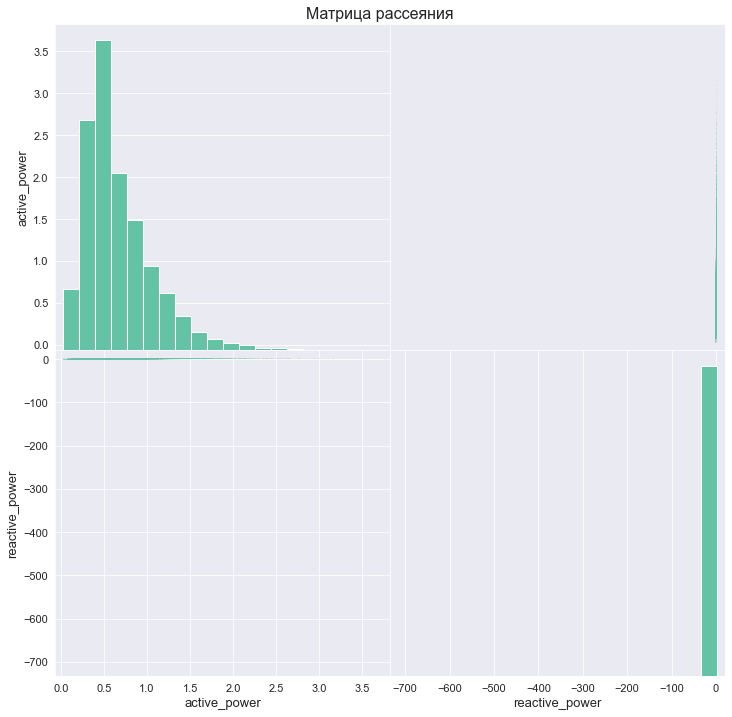

In [31]:
smatrix(data_arc[['active_power', 'reactive_power']], 12)

- Нереальное по физическому смыслу распределение реактивной мощности (как по модулю, так и по знаку).
- Отсутствие взаимосвязи между активной и реактивной мощностями.

##### Коэффициент phik и корреляция 

- Более корректно исследовать зависимости в данных по коэффициенту `phik`, т.к. он учитывает и нелинейные взаимосвязи в данных, в отличии от `корреляции Пирсона`, но для проверки отобразим обе величины.

In [32]:
def phik_corr_plot(df: pd.DataFrame, figsize: tuple, wspace: float, hspace: float,
                   nrows: int, ncols: int, y_title: float, method: str):
    
    '''Сохраним матрицы зависимостей по значениям коэффициента phik и корреляции Пирсона в отдельные переменные.'''
    
    phik_overview = df.phik_matrix(df.columns)
    correlation = df.corr(method = method)
    
    '''Построим тепловые карты взаимосвязей.'''
    
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
        
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    
    fig.suptitle('Сравнение зависимостей между признаками на тепловых картах', y = y_title, fontsize = 18)
    
    for i, rel, cmap, title, center, vmin in zip(range(2),
                                                 [phik_overview, correlation],
                                                 ['Blues', 'RdBu'],
                                                 ['Коэффициент Phik', 'Корреляция Пирсона/Спирмена'],
                                                 [None, 0],
                                                 [0, -1]):
        
       
        sns.heatmap(rel,
                    annot=True,
                    annot_kws={"size": 14},
                    fmt= '.2f',
                    ax=ax[i],
                    cmap=cmap,
                    center=center,
                    vmax=1,
                    vmin=vmin,
                    linewidths=1.0)
        
        ax[i].set_title(f'{title}', fontsize = 14, y=1.005);  

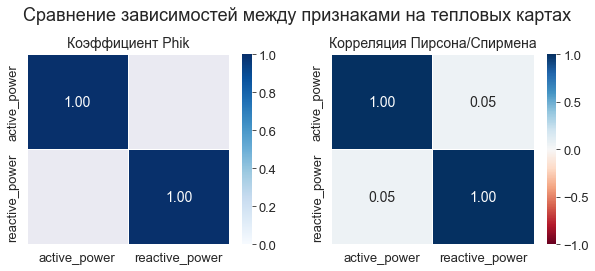

In [33]:
phik_corr_plot (data_arc[['active_power', 'reactive_power']],
                figsize=(10, 3.5), wspace=.2, hspace=None, nrows=1, ncols=2, y_title=1.07, method = 'pearson')

- Графические наблюдения подтвердились коэффициентами взаимосвязей (линейными и нелинейными).
- В датасете явные аномалии, т.к. активная и реактивная мощности связаны физической формулой и взаимосвязь между ними не может быть близкой к нулю. Далее более подробно изучим распределения, чтобы выявить аномалии.

#### Данные о подаче сыпучих материалов (объём)

##### Коэффициент phik и корреляция

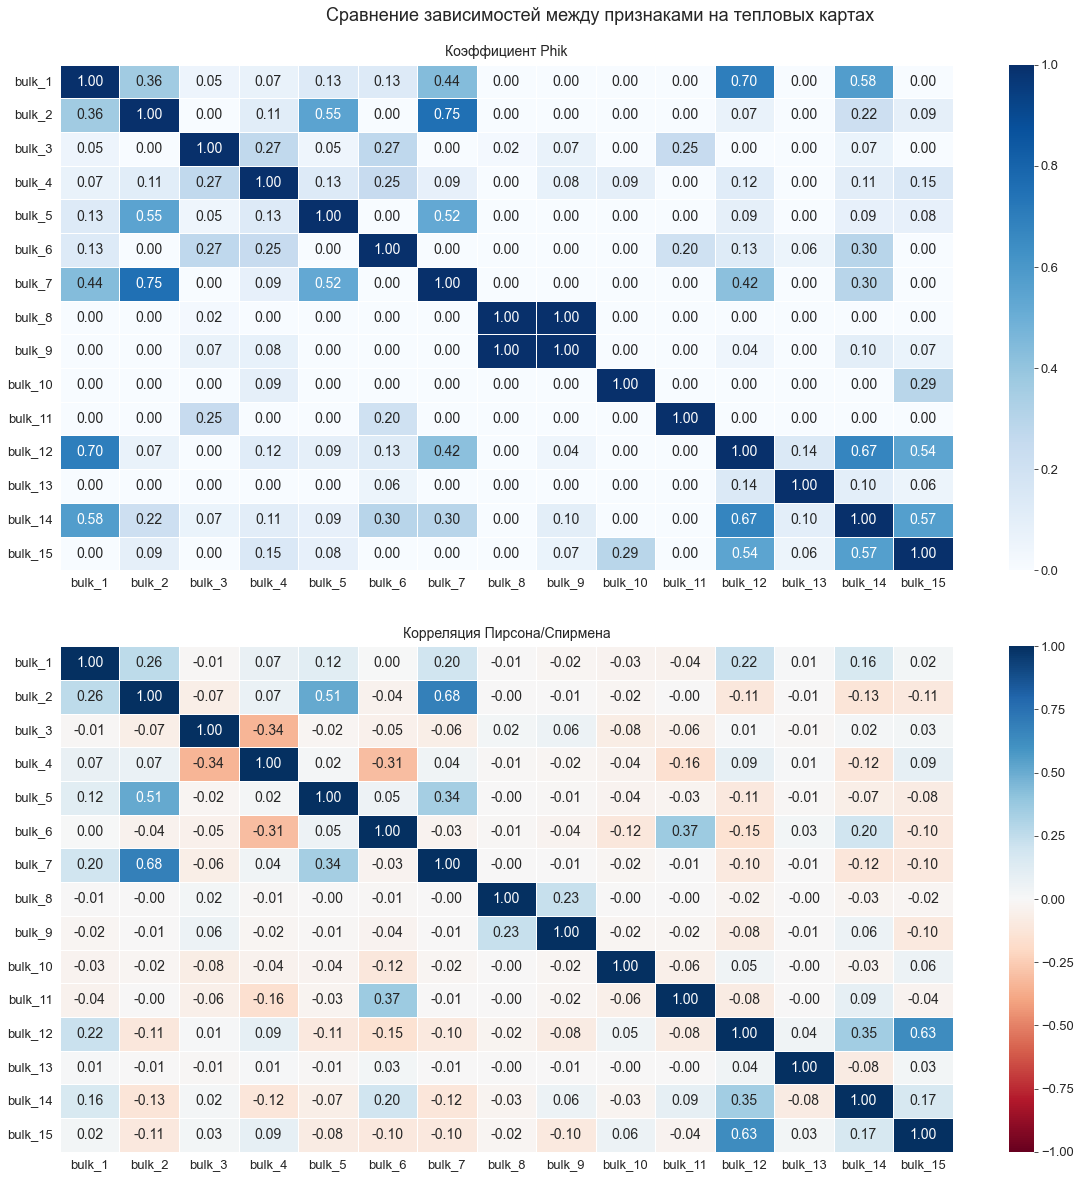

In [34]:
phik_corr_plot (data_bulk.drop('key', axis=1),
                figsize=(20, 20), wspace=None, hspace=.15, nrows=2, ncols=1, y_title=.92, method = 'spearman')

- Сильные зависимости между парами признаков:
    - `bulk_8` и `bulk_9`,
    - `bulk_2` и `bulk_7`,
    - `bulk_12` и `bulk_1`.
- Остальные взаимосвязи меньше.
- Если не найдутся аномалии в данных и не удастся достичь требуемого качества, заказчику будет предложено сократить количество признаков для улучшения качества модели.

#### Данные о подаче проволочных материалов (объём)

##### Коэффициент phik и корреляция

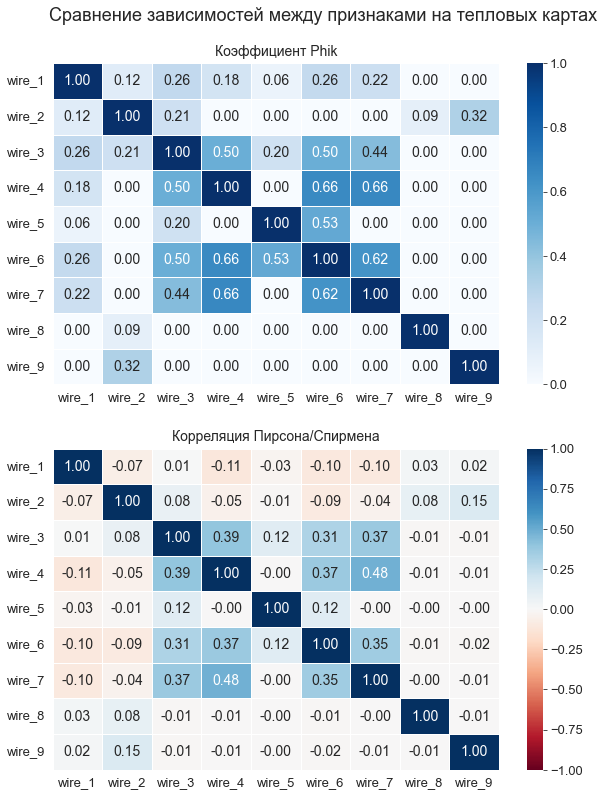

In [35]:
phik_corr_plot (data_wire.drop('key', axis=1),
                figsize=(10, 13), wspace=None, hspace=.2, nrows=2, ncols=1, y_title=.94, method = 'spearman')

- Высоких значений коэффициентов взаимосвязей в данных не выявлено, следовательно машинное обучение будет эффективнее.

### Распределение мощности

In [36]:
def hist_box (df: pd.DataFrame, col: 'name of column', bins: int):    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          gridspec_kw={'height_ratios': (.2, .8)},
                                          figsize=(18,8))
    fig.subplots_adjust(hspace=0.05)
    
    fig.suptitle(f'Распределение значений в признаке {col}', y=.912)
    
    sns.boxplot(x=df[col], ax=ax_box)
    sns.histplot(x=df[col], bins=bins, ax=ax_hist)    
    
    ax_box.set(xlabel = '')
    ax_hist.axvline(df[col].mean(),color='orange',linestyle='-')
    ax_hist.axvline(df[col].median(),color='orchid',linestyle='--');
    
    ax_hist.legend(['среднее', 'медиана', 'распределение']);

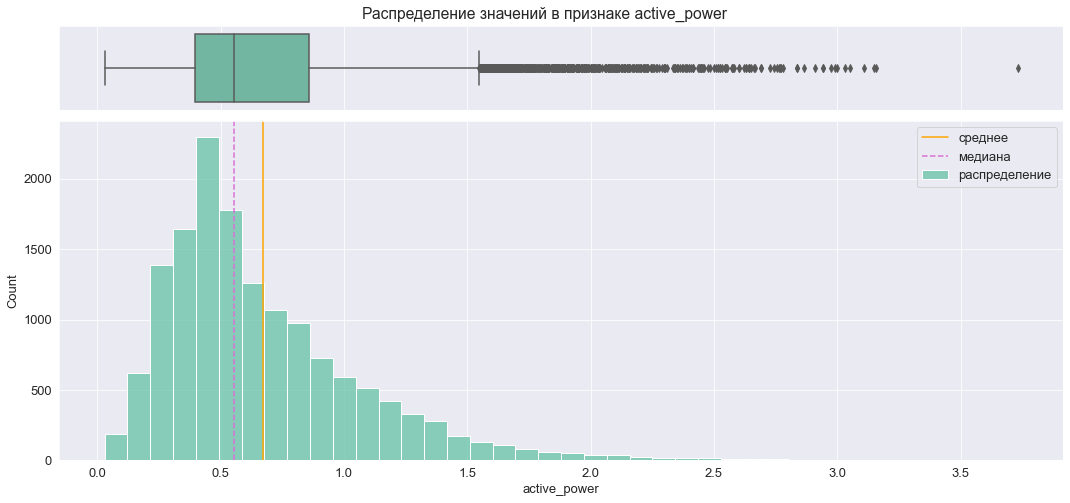

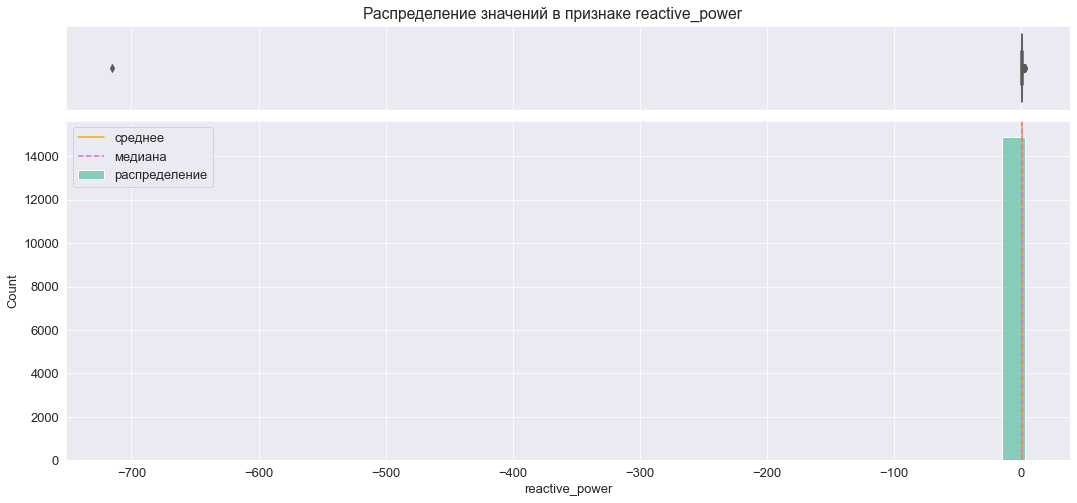

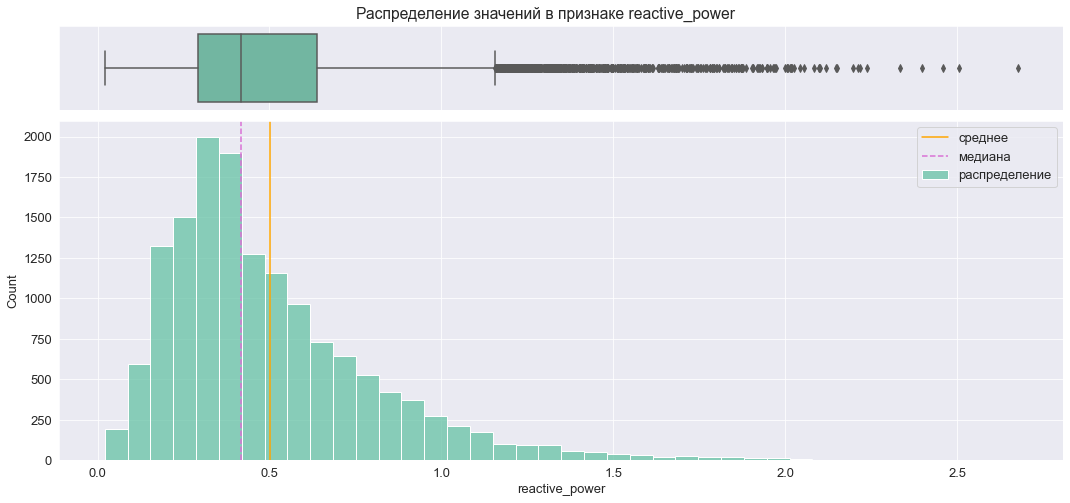

In [37]:
hist_box (data_arc, 'active_power', bins=40)
hist_box (data_arc, 'reactive_power', bins=40)
hist_box (data_arc.loc[data_arc['reactive_power']>=0], 'reactive_power', bins=40)

- Значение реактивной мощности (Q) для данного технологического процесса не может быть меньше нуля, т.к. емкостная нагрузка отсутствует. Значения Q<0 это аномалии, которые необходимо удалить.
- Распределение данных по мощностям (если исключить аномалии) со смещением вправо.

Посмотрим, сколько аномальных значений

In [38]:
data_arc.loc[data_arc['reactive_power']<0]['reactive_power'].value_counts()

-715.505    1
Name: reactive_power, dtype: int64

- Заказчику важно работать только с проверенными данными.
- Целевой признак - последняя измеренная температура.

Следовательно необходимо проверить, на каком этапе в партии появилась данная аномалия.

In [39]:
data_arc.loc[data_arc['key'].isin(data_arc.loc[data_arc['reactive_power']<0]['key'])]

key       start_heating         end_heating  active_power  \
9778  2116 2019-07-24 00:29:52 2019-07-24 00:31:54         0.433   
9779  2116 2019-07-24 00:35:50 2019-07-24 00:38:05         0.620   
9780  2116 2019-07-24 00:44:48 2019-07-24 00:46:37         0.496   
9781  2116 2019-07-24 00:51:51 2019-07-24 00:52:58         0.299   

      reactive_power  
9778           0.306  
9779           0.408  
9780        -715.505  
9781           0.199

Аномалия появилась не на последней итерации.

Удалим аномалию.

In [40]:
data_arc = data_arc.loc[data_arc['reactive_power']>=0]

### Распределение газа

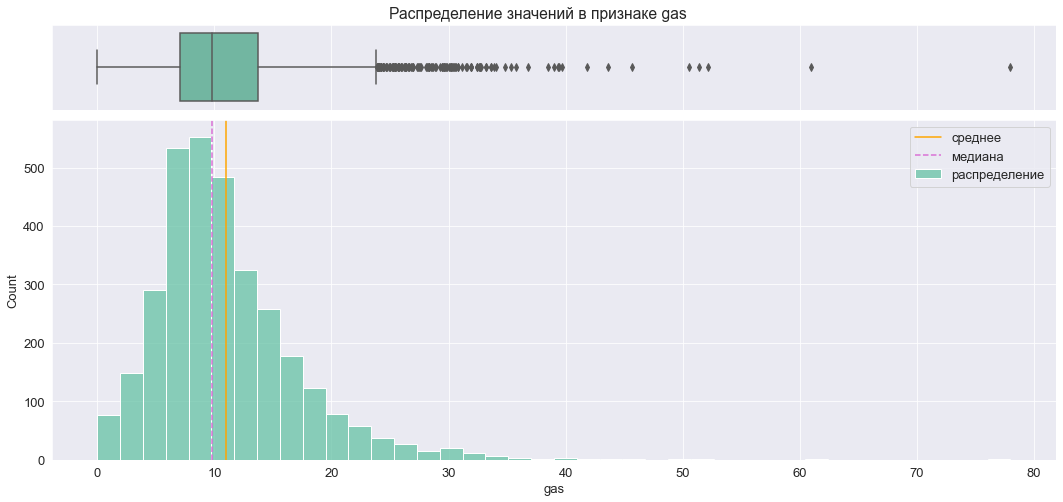

In [41]:
hist_box (data_gas, 'gas', bins=40)

- Распределение данных со смещением вправо.
- На данном этапе оставим данные без изменений.

### Диаграммы размаха по объёму сыпучих материалов

In [42]:
def box_all (df: pd.DataFrame):
    plt.figure(figsize=(18,8))
    plt.title(f'Диаграммы размаха для материалов в датасете')
    sns.boxplot(data=df.drop('key', axis=1));

- Ранее все пропуски в данной таблице были заменены нулями по обновленным исходным данным от заказчика.
- Для адекватности анализа рассмотрим ненулевые данные.

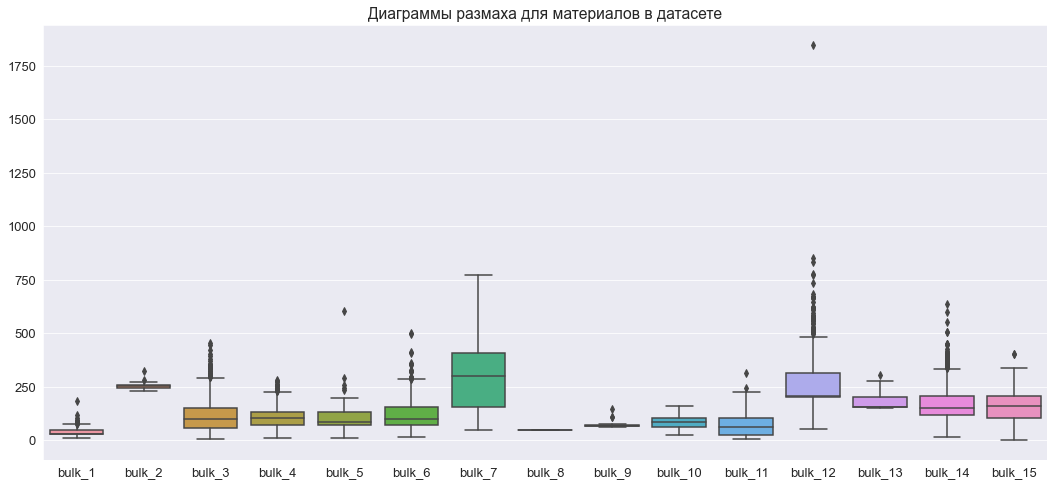

In [43]:
box_all (data_bulk[data_bulk != 0])

- имеются редкие и выбиющиеся значения
- в основном все материалы распределены в датасете со смещениями распределений
- необходимо дополнительно проверить `bulk_8` и `bulk_9`

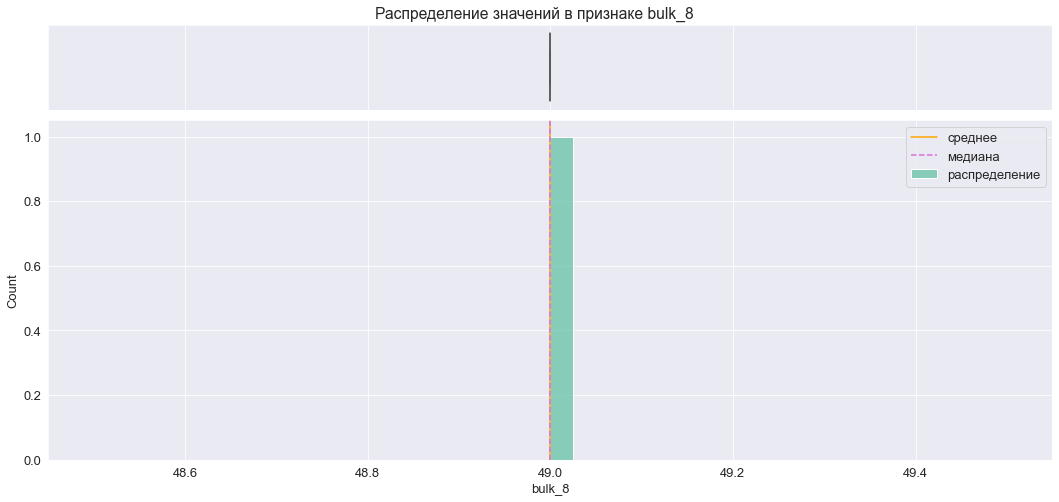

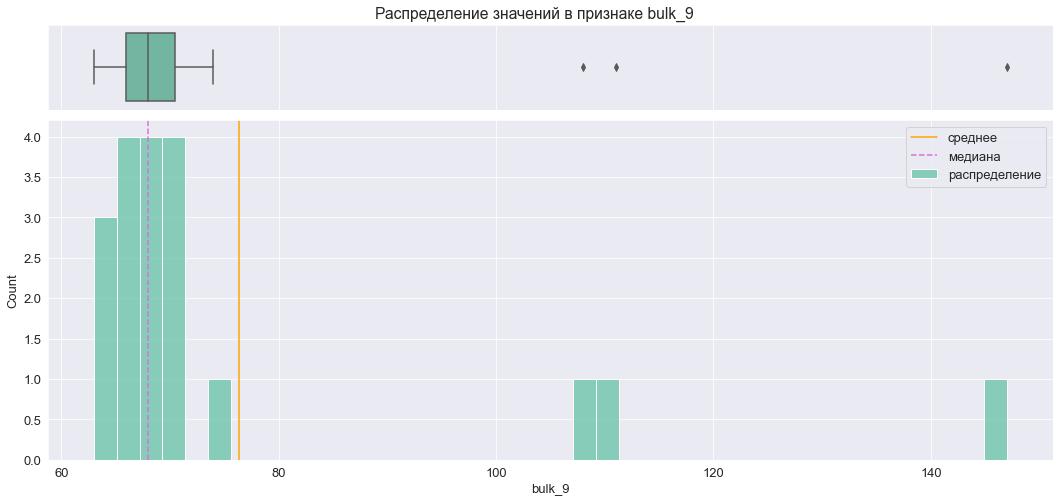

In [44]:
hist_box (data_bulk[data_bulk != 0], 'bulk_8', bins=40)
hist_box (data_bulk[data_bulk != 0], 'bulk_9', bins=40)

- распределение данных в признаке `bulk_9` приемлемо

Посмотрим количество уникальных значений в признаке `bulk_8`

In [45]:
data_bulk[data_bulk != 0]['bulk_8'].value_counts()

49.000    1
Name: bulk_8, dtype: int64

Удалим данный признак, т.к. по одному значению модель точно не сможет найти закономерности в данных.

In [46]:
data_bulk = data_bulk.drop('bulk_8', axis=1)

### Диаграммы размаха по объёму проволочных материалах

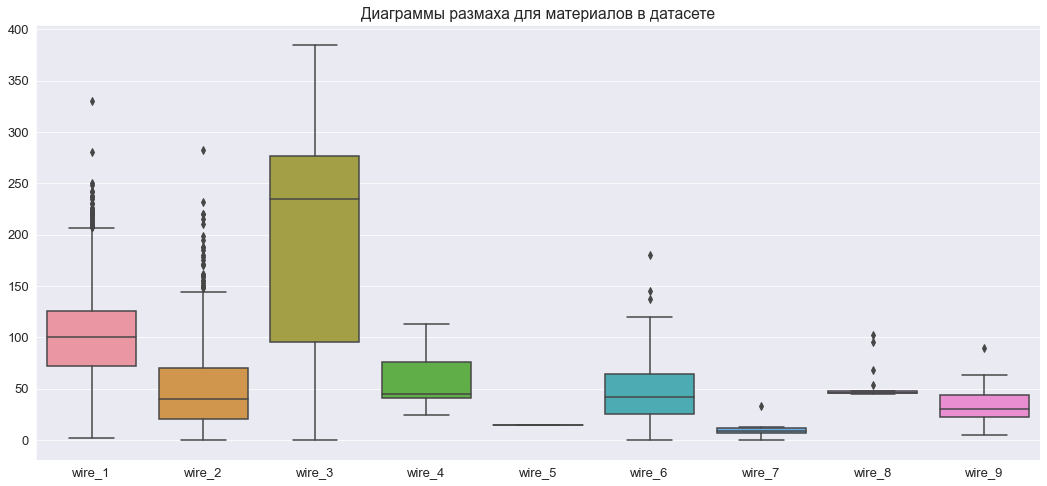

In [47]:
box_all (data_wire[data_wire != 0])

- имеются редкие и выбиющиеся значения
- в основном все материалы распределены в датасете со смещениями распределений
- необходимо дополнительно проверить `wire_5` и `wire_8`

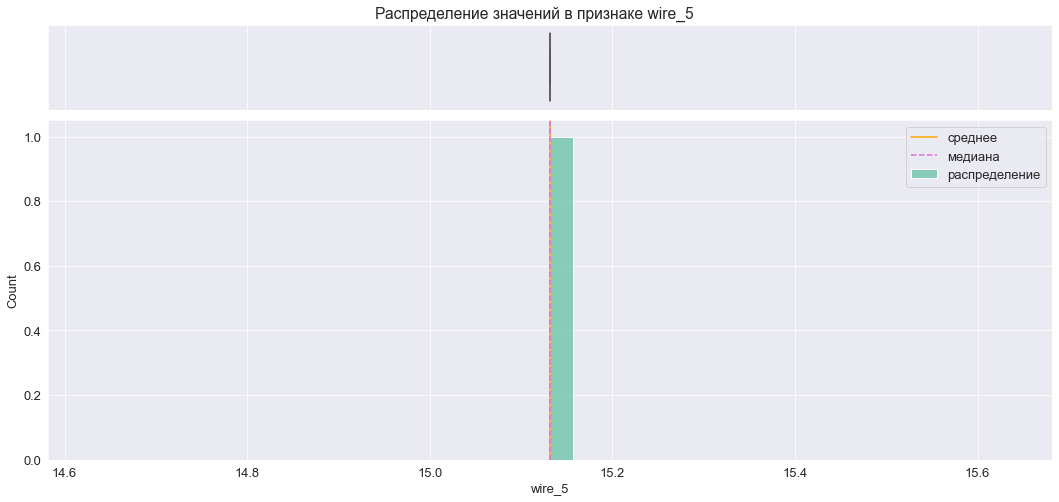

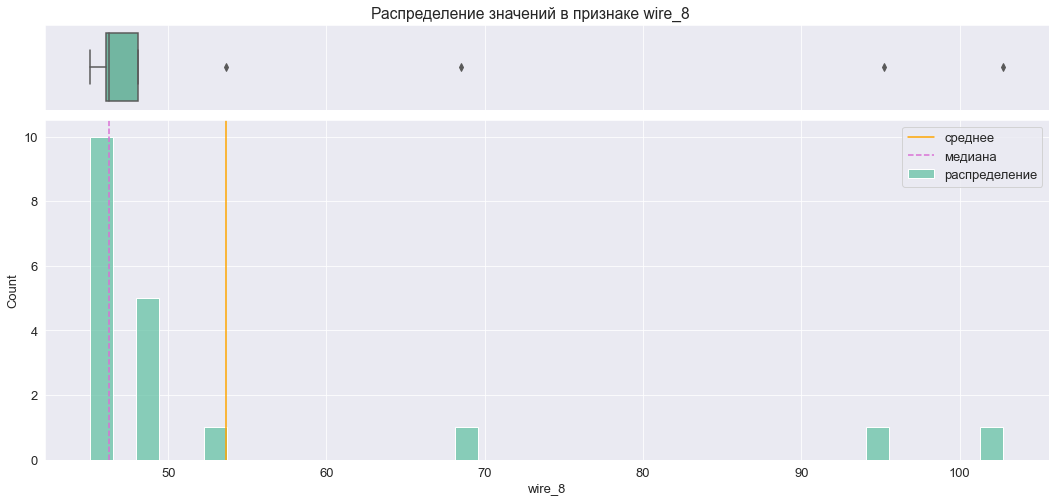

In [48]:
hist_box (data_wire[data_wire != 0], 'wire_5', bins=40)
hist_box (data_wire[data_wire != 0], 'wire_8', bins=40)

- распределение данных в признаке `wire_8` приемлемо

Посмотрим количество уникальных значений в признаке `wire_5`

In [49]:
data_wire[data_wire != 0]['wire_5'].value_counts()

15.132    1
Name: wire_5, dtype: int64

Удалим данный признак, т.к. по одному значению модель точно не сможет найти закономерности в данных.

In [50]:
data_wire = data_wire.drop('wire_5', axis=1)

### Столбчатая диаграмма по количеству итераций

Столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Построим столбчатую диаграмму для изучения количества партий с зависимости от количества итераций.

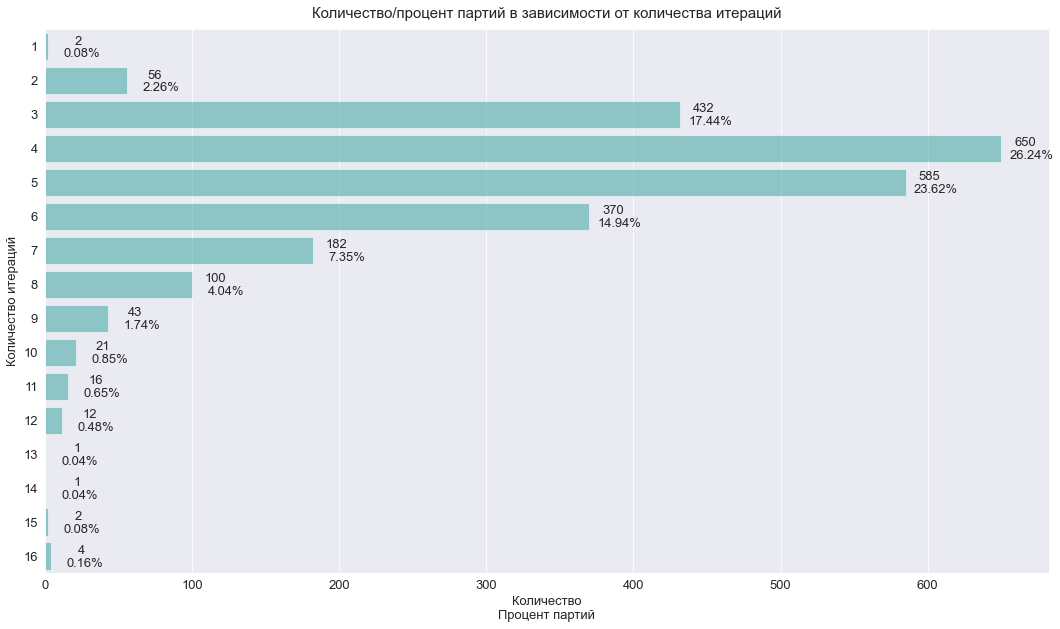

In [51]:
plt.figure(figsize=(18, 10))
plt.title('Количество/процент партий в зависимости от количества итераций', fontsize=15, y=1.01)

ax = sns.countplot(data=pd.DataFrame(data_temp['key'].value_counts()).rename(columns={'key':'iterations'}),
                   y='iterations', dodge=False, color = 'lightseagreen', alpha=.5)

plt.xlabel('Количество\nПроцент партий')
plt.ylabel('Количество итераций')

total = len(pd.DataFrame(data_temp['key'].value_counts()))
for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width() +32, p.get_y() + p.get_height()/1.3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width() +20, p.get_y() + p.get_height()/3.2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center') 

Согласно исходным данным:
>Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Температуру измеряют как минимум 2 раза, следовательно объекты с уникальным значением в признаке `key` (одна итерация) не подходят для задачи заказчика.

Массив ключей с одной итерацией

In [52]:
key_1_iter = data_temp['key'].value_counts()[data_temp['key'].value_counts() == 1].index

Отфильтруем датасет, оставим данные с количеством итераций > 1.

In [53]:
data_temp = data_temp[~data_temp['key'].isin(key_1_iter)]

### Распределение температуры

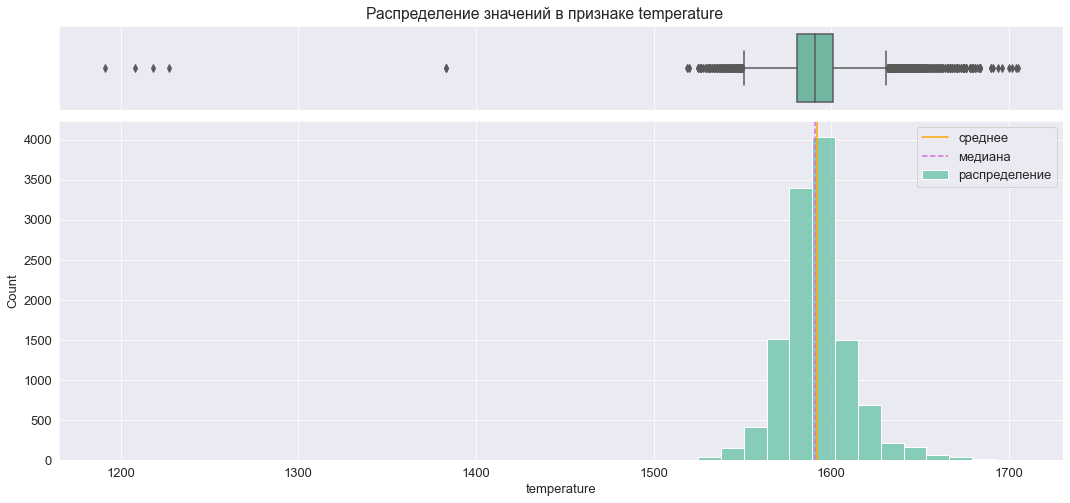

In [54]:
hist_box (data_temp, 'temperature', bins=40)

- имеются редкие и выбивающиеся значения, похожие на аномалии
- распределение со смещением влево

Согласно технологии все этапы обработки происходят с расплавленной сталью, температура плавления стали 1400—1520 °C, соответственно, значения ниже это выбросы, которые необходимо удалить.

Удаление аномалий

In [55]:
data_temp = data_temp[data_temp['temperature']>1400]

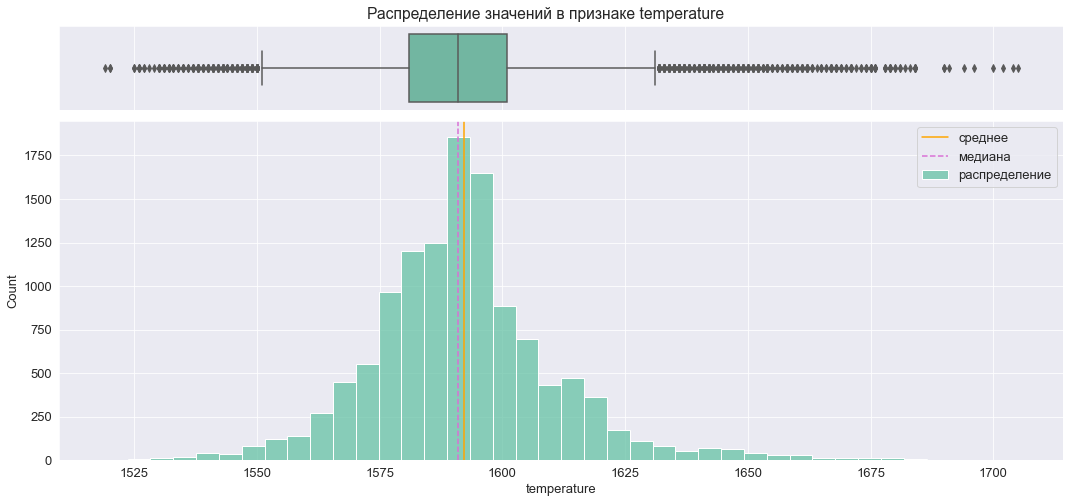

In [56]:
hist_box (data_temp, 'temperature', bins=40)

- распределение данных в целевом признаке близко к нормальному, что должно положительно сказаться на качестве модели

### Выводы по EDA

- Поставленная задача уточнена и ясна.
- Технологический процесс изучен для дальнейшего принятия решений по использованию данных.
- Полученные от заказчика данных прочитаны, произведена работа с дубликатами, пропусками, наименованиями столбцов, типами данных.
- Выявлены признаки, коррелирующие между собой, произведена оптимизация количества признаков.
- Выявлены и удалены аномалии и признаки, неудовлетворяющие исходным данным.

## Подготовка данных к машинному обучению

### Сохранение значения параметра псевдослучайности в переменной

In [57]:
seed = 3102022

### Данные с результатами измерения температуры

- Согласно уточненным исходным данным от заказчика целевым признаком является ***последняя*** измеренная температура

Проверим, нет ли явных дубликатов в столбце `time_measure`

In [58]:
print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов:'+color.END)
print(data_temp['time_measure'].duplicated().sum())


Количество явных дубликатов:
0


Проверим, возрастают ли монотонно по партиям значения в столбце `time_measure`

In [59]:
mono_time = [data_temp[data_temp['key']==i]['time_measure'].is_monotonic_increasing for i in data_temp['key'].unique()]

In [60]:
if pd.Series(mono_time).unique() == True:
    print (color.BOLD+color.OKGREEN+'Время по партиям упорядоченно по возрастанию')
else:
    print (color.BOLD+color.FAIL+'Время по партиям не упорядоченно по возрастанию')

Время по партиям упорядоченно по возрастанию


Сгруппируем данные по признаку `key`:
- `time_start` - время первого замера температуры партии
- `time_end` - время последнего замера температуры партии
- `temp_start` - температура при первом замере
- `temp_end` - температура при последнем замере

In [61]:
data_temp = data_temp.groupby('key')[['time_measure', 'temperature']].agg(time_start = ('time_measure','min'),
                                                                          time_end   = ('time_measure','max'),
                                                                          temp_start = ('temperature','first'),
                                                                          temp_end   = ('temperature','last'))

In [62]:
data_temp.head(3)

time_start            time_end  temp_start  temp_end
key                                                              
1   2019-05-03 11:16:18 2019-05-03 11:30:39    1571.000  1613.000
2   2019-05-03 11:37:27 2019-05-03 11:59:12    1581.000  1602.000
3   2019-05-03 12:13:17 2019-05-03 12:34:57    1596.000  1599.000

Добавим признак `time_total` - время от первого до последнего замера в секундах

In [63]:
data_temp['time_total'] = (data_temp['time_end'] - data_temp['time_start'])
data_temp['time_total'] = data_temp['time_total'].dt.total_seconds()
data_temp = data_temp[['time_start', 'time_end', 'time_total', 'temp_start', 'temp_end']]

In [64]:
data_temp.head(3)

time_start            time_end  time_total  temp_start  temp_end
key                                                                          
1   2019-05-03 11:16:18 2019-05-03 11:30:39     861.000    1571.000  1613.000
2   2019-05-03 11:37:27 2019-05-03 11:59:12    1305.000    1581.000  1602.000
3   2019-05-03 12:13:17 2019-05-03 12:34:57    1300.000    1596.000  1599.000

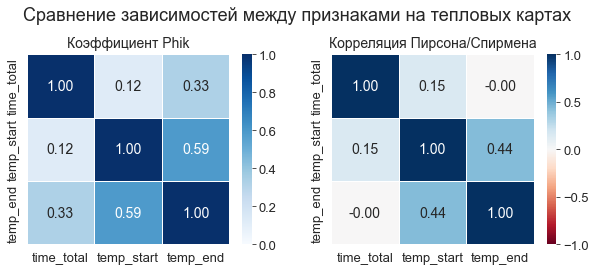

In [65]:
phik_corr_plot (data_temp[['time_total', 'temp_start', 'temp_end']],
                figsize=(10, 3.5), wspace=.2, hspace=None, nrows=1, ncols=2, y_title=1.07, method='pearson')

Для дальнейшего машинного обучения исключим признаки формата `datetime`, т.к. они учтены в признаке `time_total`.

In [66]:
df_temp = data_temp[['temp_end', 'temp_start', 'time_total']]

### Данные об электродах

Из курса ТОЭ (теоретические основы электротехники) известно: 

$S=\sqrt {P^2+Q^2},$

где:
- $S$ - полная мощность
- $P$ - активная мощность
- $Q$ - реактивная мощность

А также
$tgφ=\large\frac{Q}{P},$

где:
- $φ$ - угол между векторами полной и активной и полной мощностей

Т.к. активная и реактивная мощности между собой связаны формулой, логично заменить признаки с активной и реактивной мощностями на признак с полной мощностью `full_power`, т.к. это упростит модели обучение и может положительно повлиять на качество.

In [67]:
data_arc['full_power'] = np.sqrt(data_arc['active_power']**2+data_arc['reactive_power']**2)

На данном этапе удалять признаки `active_power` и `reactive_power` не будем, т.к. возможно при построении модели машинного обучения будем подбирать оптимальный набор признаков.

Сгруппируем данные по признаку `key`: 	
- `start_heating` - начало нагрева дугой партии
- `end_heating` - конец нагрева дугой партии
- `active_power` - суммарная активная мощность партии
- `reactive_power` - суммарная реактивная мощность партии
- `full_power` - суммарная полная мощность партии

In [68]:
data_arc = data_arc.groupby('key').agg({'start_heating'  : 'min',
                                        'end_heating'    : 'max',
                                        'active_power'   : 'sum',
                                        'reactive_power' : 'sum',
                                        'full_power'     : 'sum'})

In [69]:
data_arc.head(3)

start_heating         end_heating  active_power  reactive_power  \
key                                                                         
1   2019-05-03 11:02:14 2019-05-03 11:28:37         4.878           3.183   
2   2019-05-03 11:34:14 2019-05-03 11:53:18         3.053           1.998   
3   2019-05-03 12:06:54 2019-05-03 12:32:19         2.526           1.599   

     full_power  
key              
1         5.826  
2         3.649  
3         2.990

Добавим признак `heating_total` - время нагрева дугой партии в секундах

In [70]:
data_arc['heating_total'] = (data_arc['end_heating'] - data_arc['start_heating'])
data_arc['heating_total'] = data_arc['heating_total'].dt.total_seconds()

Добавим следующие признаки:
- `active_power_s` - суммарная активная мощность за время нагрева дугой партии
- `reactive_power_s` - суммарная реактивная мощность за время нагрева дугой партии
- `full_power_s` - суммарная полная мощность за время нагрева дугой партии

In [71]:
for col in ['active_power', 'reactive_power', 'full_power']:
    data_arc[f'{col}_s'] = data_arc[col] * data_arc['heating_total']

In [72]:
data_arc = data_arc[['start_heating', 'end_heating', 'heating_total',
                     'active_power', 'reactive_power', 'full_power',
                     'active_power_s', 'reactive_power_s', 'full_power_s']]

In [73]:
data_arc.head(3)

start_heating         end_heating  heating_total  active_power  \
key                                                                        
1   2019-05-03 11:02:14 2019-05-03 11:28:37       1583.000         4.878   
2   2019-05-03 11:34:14 2019-05-03 11:53:18       1144.000         3.053   
3   2019-05-03 12:06:54 2019-05-03 12:32:19       1525.000         2.526   

     reactive_power  full_power  active_power_s  reactive_power_s  \
key                                                                 
1             3.183       5.826        7722.106          5039.071   
2             1.998       3.649        3492.172          2285.840   
3             1.599       2.990        3851.970          2438.591   

     full_power_s  
key                
1        9223.183  
2        4174.704  
3        4559.040

>На данном этапе исключим активную и реактивную мощности (возможно, к ним вернемся, если не достигнем требуемой метрики, для формирования иного комплекта признаков), т.к. они зависят друг от друга и по ним вычисляется полная мощность.

>Исключим признаки `start_heating` и `end_heating`, т.к. по ним вычисляется признак `heating_total`

- Проверим взаимосвязи между оставшимися признаками.

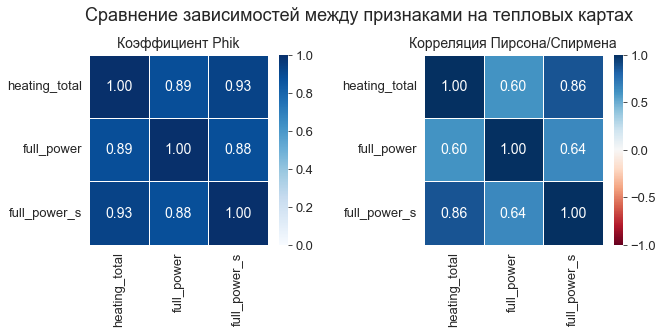

In [74]:
phik_corr_plot (data_arc[['heating_total', 'full_power', 'full_power_s']],
                figsize=(10, 3.5), wspace=.5, hspace=None, nrows=1, ncols=2, y_title=1.07, method='pearson')

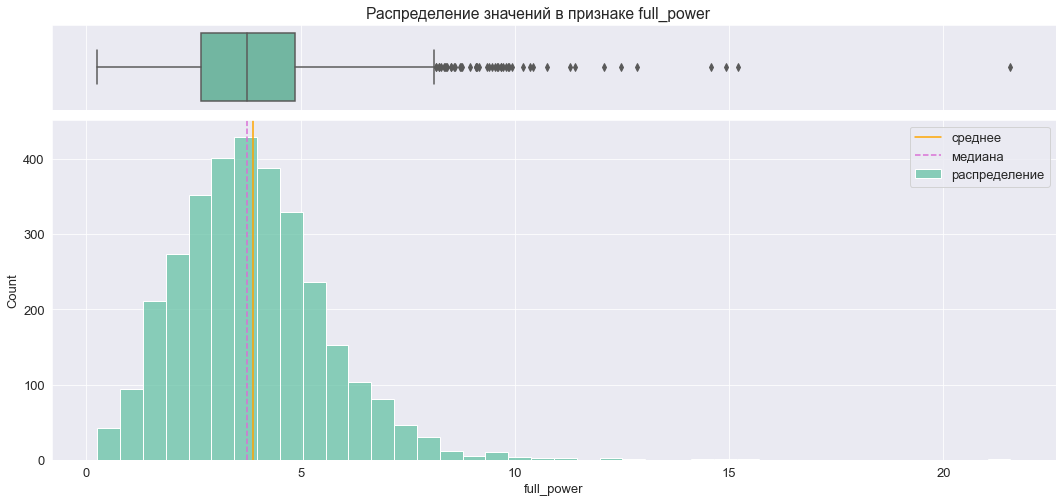

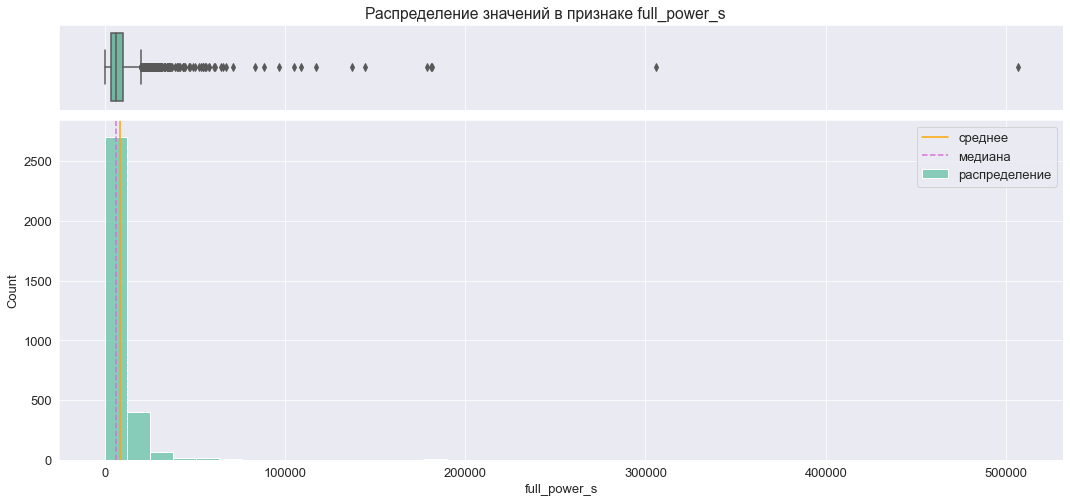

In [75]:
hist_box (data_arc, 'full_power', bins=40)
hist_box (data_arc, 'full_power_s', bins=40)

- `full_power_s` сразу исключим из-за максимальных взаимосвязей, а также по причине более далекого от нормального распределения данных. 
- `heating_total` имеет меньшую взаимосвязь с `full_power`, но тем не менее сильную. Т.к. целевой признак **последняя измеренная температура**, а два времени между собой будут явно сильно коррелировать, то считаю логичным в финальных данных оставить признак `time_total` из датасета `df_temp`, а `heating_total` исключить.

In [76]:
df_arc = data_arc[['full_power']]

### Объединение в общий датасет

Перед объединением установим столбеу `key` в качестве индекса в датасетах, где ранее этого сделано не было.

In [77]:
df_bulk = data_bulk.set_index('key')
df_gas = data_gas.set_index('key')
df_wire = data_wire.set_index('key')

- Т.к. заказчику важно учитывать, только те данные, в которых уверены, то объединять таблицы будем при помощи параметра `inner` - по пересечению ключей из всех таблиц.

In [78]:
df = df_temp.join([df_arc, df_gas, df_bulk, df_wire], how='inner')

In [79]:
df.head(3)

temp_end  temp_start  time_total  full_power    gas  bulk_1  bulk_2  \
key                                                                        
1    1613.000    1571.000     861.000       5.826 29.750   0.000   0.000   
2    1602.000    1581.000    1305.000       3.649 12.556   0.000   0.000   
3    1599.000    1596.000    1300.000       2.990 28.555   0.000   0.000   

     bulk_3  bulk_4  bulk_5  ...  bulk_14  bulk_15  wire_1  wire_2  wire_3  \
key                          ...                                             
1     0.000  43.000   0.000  ...  150.000  154.000  60.060   0.000   0.000   
2     0.000  73.000   0.000  ...  149.000  154.000  96.052   0.000   0.000   
3     0.000  34.000   0.000  ...  152.000  153.000  91.160   0.000   0.000   

     wire_4  wire_6  wire_7  wire_8  wire_9  
key                                          
1     0.000   0.000   0.000   0.000   0.000  
2     0.000   0.000   0.000   0.000   0.000  
3     0.000   0.000   0.000   0.000   0.000  

[3 rows x 27 columns]

### Проверка взаимосвязей между признаками

#### Матрица рассеяния

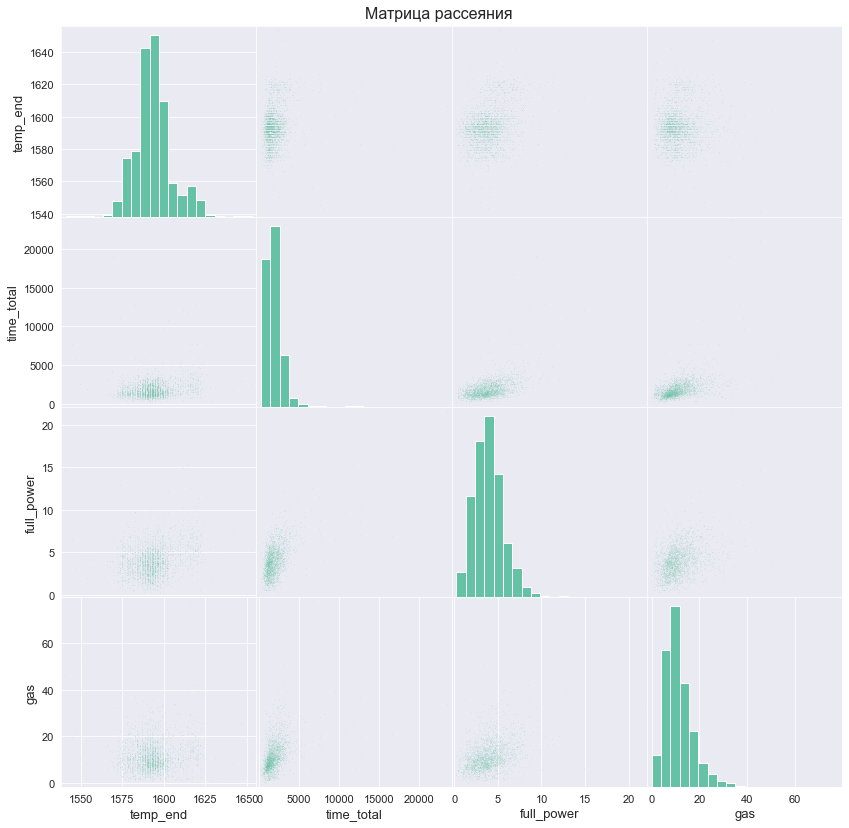

In [80]:
smatrix(df[['temp_end', 'time_total', 'full_power', 'gas']], 14)

#### Коэффициент phik и корреляция

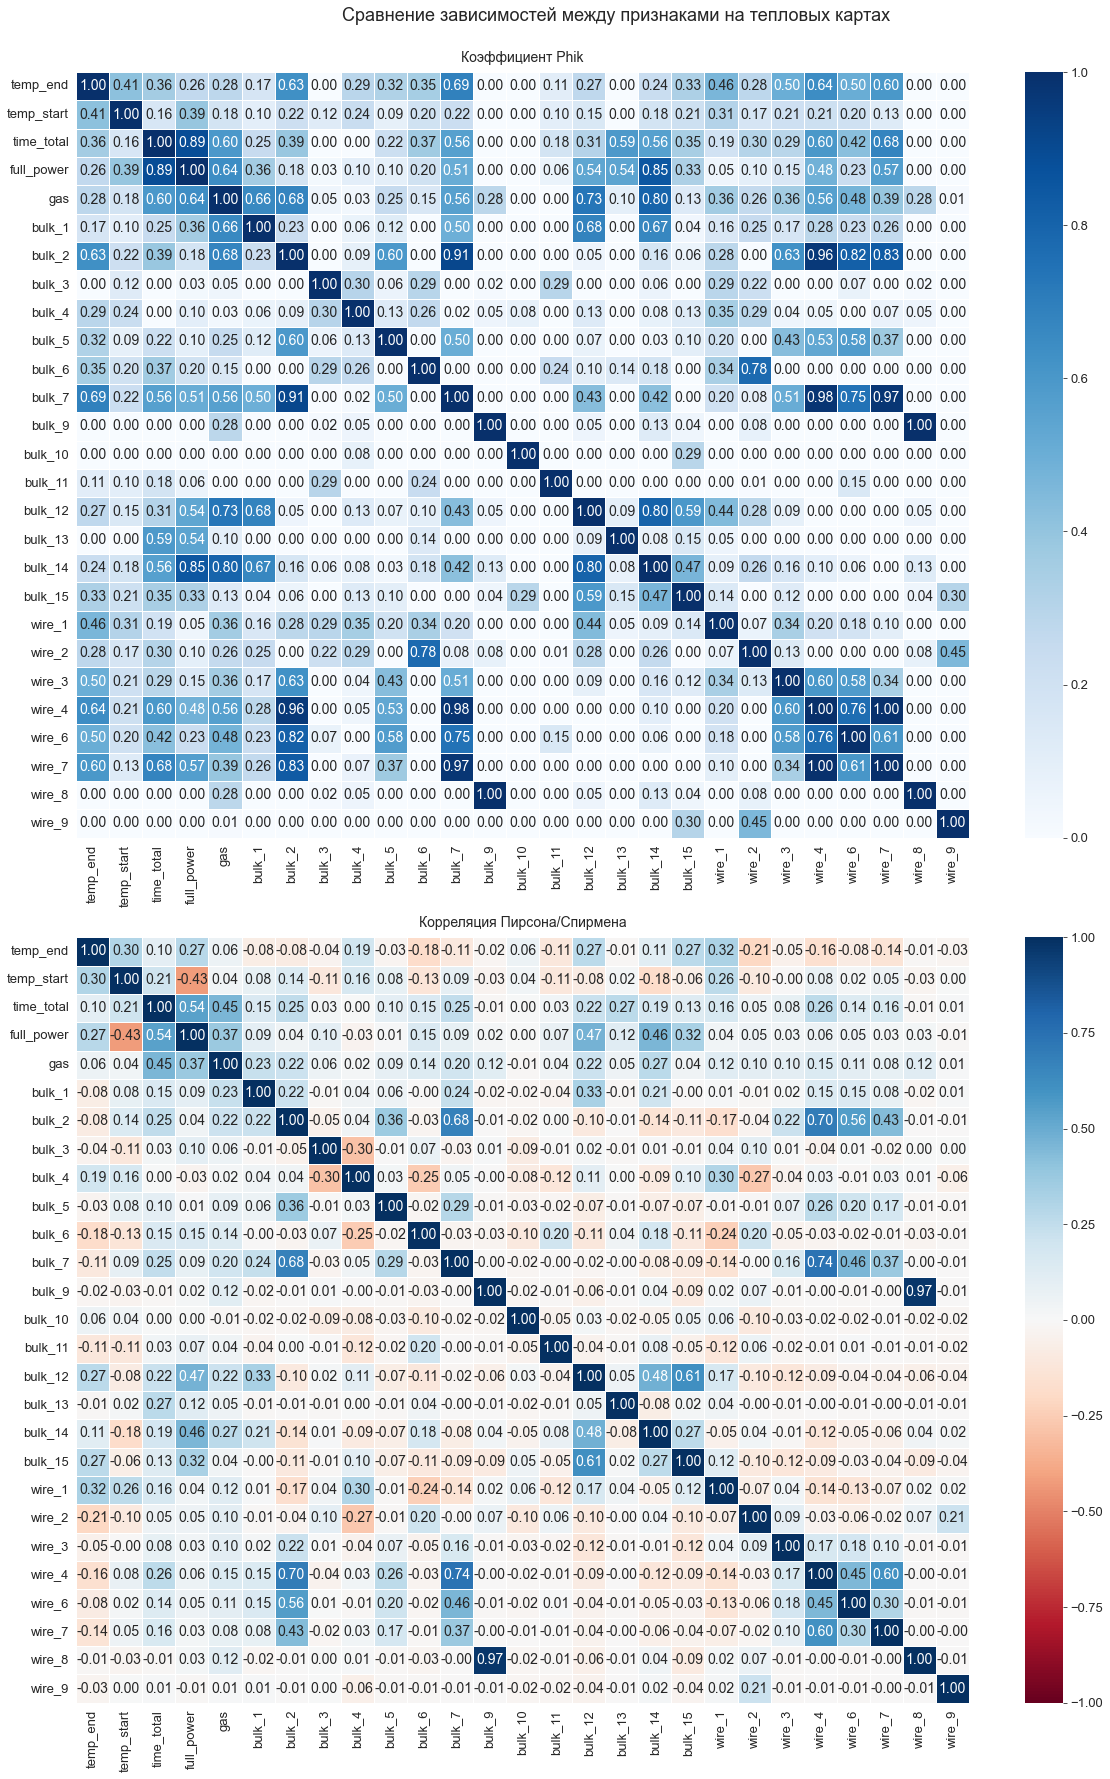

In [81]:
phik_corr_plot (df,
                figsize=(20, 30), wspace=None, hspace=.13, nrows=2, ncols=1, y_title=.91, method='pearson')

Дополнительно изучим корреляцию Спирмена для материалов.

Коэффициент корреляции Спирмена — мера линейной связи между случайными величинами. Корреляция Спирмена является ранговой, то есть для оценки силы связи используются не численные значения, а соответствующие им ранги.

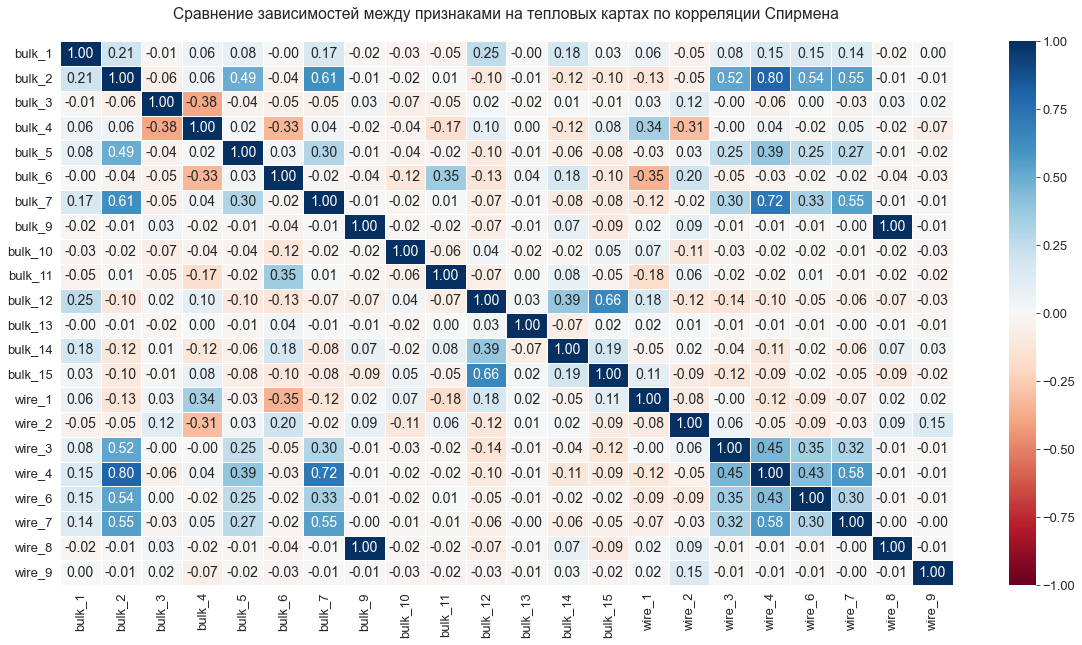

In [82]:
plt.figure(figsize=(20,10))
plt.title(f'Сравнение зависимостей между признаками на тепловых картах по корреляции Спирмена', y=1.03)

sns.heatmap(df.drop(['temp_end', 'temp_start', 'time_total', 'full_power', 'gas'], axis=1).corr(method = 'spearman'),
            annot=True,
            annot_kws={"size": 14},
            fmt= '.2f',
            cmap='RdBu',
            center=0,
            vmax=1,
            vmin=-1,
            linewidths=1.0);

| <font size="2">Пары мультиколинеарных признаков | <font size="2">Решение |
| :--- | :--- |
| <font size="2"> *bulk_7* и *bulk_2* | <font size="2">удаление *bulk_2* из-за меньшей взаимосвязи с целевым признаком |
| <font size="2"> *wire_4* и *bulk_2* | <font size="2">ранее принято решение об удалении *bulk_2* |
| <font size="2"> *wire_4* и *bulk_7* | <font size="2">удаление *wire_4* из-за меньшей взаимосвязи с целевым признаком |
| <font size="2"> *bulk_7* и *wire_7* | <font size="2">удаление *wire_7* из-за меньшей взаимосвязи с целевым признаком |
| <font size="2"> *bulk_9* и *wire_8* | <font size="2">удаление и *bulk_9*, и *wire_8* из-за отсутствия взаимосвязи с целевым признаком |
    
- Признаки, имеющие минимальные взаимосвязи с целевым признаком, на данном этапе оставим без изменений. Вернемся к решению об их удалении после результатов машинного обучения.

Исключение мультиколлинеарности.

In [83]:
df = df.drop(['bulk_2', 'wire_4', 'wire_7', 'bulk_9', 'wire_8'], axis=1)

#### Функция создания переменных для фичей и таргета, деление на выборки

Создадим функцию `split_data()`, на вход которой подаётся:
- `df` - датафрейм для соответствующей модели,
- `valid` - флаг наличия валидационной выборки (True или False).

На выходе функции:
- при налиии валидационной выборки:

    - `target` - целевой признак,
    - `target_train` - целевой признак обучающей выборки,
    - `target_valid` - целевой признак валидационной выборки, 
    - `target_test` - целевой признак тестовой выборки,
    - `features` - признаки,
    - `features_train` - признаки обучающей выборки,
    - `features_valid` - признаки валидационной выборки,
    - `features_test` - признаки тестовой выборки.
    
    
- при отсутствии валидационной выборки:

    - `target` - целевой признак,
    - `target_train` - целевой признак обучающей выборки,
    - `target_test` - целевой признак тестовой выборки,
    - `features` - признаки,
    - `features_train` - признаки обучающей выборки,
    - `features_test` - признаки тестовой выборки.

In [84]:
def split_data (df: pd.DataFrame,
                valid: 'bool - True or False'):
    
    '''Создание переменных для признаков и целевого признака'''
    
    target = df['temp_end']
    features = df.drop('temp_end', axis=1)
    
    '''Деление данных на выборки'''
    
    if valid == True:
        features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                      target,
                                                                                      shuffle=True,
                                                                                      test_size=.4,
                                                                                      random_state=seed)
        features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                                    target_valid,
                                                                                    shuffle=True,
                                                                                    test_size=.5,
                                                                                    random_state=seed)
        
        '''Визуализация процентного соотношения размеров выборок'''
        
        selections = pd.Series({'обучающая': len(target_train),
                                'валидационная': len(target_valid),
                                'тестовая': len(target_test)})
        
        fig = plt.figure(figsize=(10, 4))
    
        pie_selections=selections.plot(kind='pie',
                                       label='',
                                       autopct='%1.0f%%',
                                       title='Соотношение\nразмеров выборок',
                                       shadow=True,
                                       wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                       colors = ['lightseagreen', 'hotpink', 'gold'],
                                       fontsize=13)
        pie_selections.title.set_size(15)  
        
        return target, target_train, target_valid, target_test, features, features_train, features_valid, features_test
    
    else:
        features_train, features_test, target_train, target_test = train_test_split(features,
                                                                                    target,
                                                                                    shuffle=True,
                                                                                    test_size=.2,
                                                                                    random_state=seed)
        
        '''Визуализация процентного соотношения размеров выборок'''
        
        selections = pd.Series({'обучающая': len(target_train),
                                'тестовая': len(target_test)})
        
        fig = plt.figure(figsize=(10, 4))
    
        pie_selections=selections.plot(kind='pie',
                                       label='',
                                       autopct='%1.0f%%',
                                       title='Соотношение\nразмеров выборок',
                                       shadow=True,
                                       wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                       colors = ['lightseagreen', 'hotpink', 'gold'],
                                       fontsize=13)
        pie_selections.title.set_size(15)  
        
        return target, target_train, target_test, features, features_train, features_test

#### Создание переменных для фичей и таргета, деление на выборки

##### Для нелинейных моделей

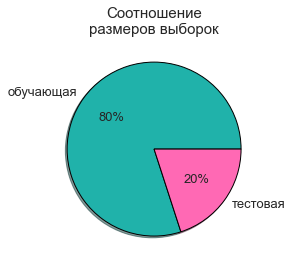

In [85]:
(y,
 y_train,
 y_test,
 X,
 X_train,
 X_test) = split_data (df, valid = False)

##### Для линейных моделей

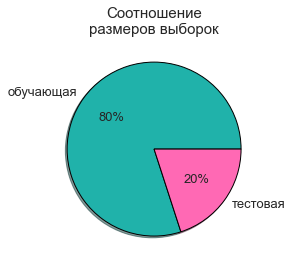

In [86]:
(y_line,
 y_line_train,
 y_line_test,
 X_line,
 X_line_train,
 X_line_test) = split_data (df, valid = False)

### Масштабирование признаков 

#### Проверка масштаба

Для начала убедимся, что у признаков разный масштаб графически на точечной диаграмме.

Напишем функцию `scaling_plot()`, т.к. действие будет повторяться.
- На вход фунция принимает признаки обучающей, тестовой и валидационной (при наличии) выборок.
- На выходе ничего не возвращает, служит для визуализации разброса значений объектов по признакам.

In [87]:
def scaling_plot(features_train, features_test, features_valid):
    
    if features_valid == None:
        n = 2
    else:
        n = 3
    
    selection = [features_train, features_test, features_valid]
    title = ['Разброс значений объектов по признакам для обучающей выборки',
             'Разброс значений объектов по признакам для тестовой выборки',
             'Разброс значений объектов по признакам для валидационной выборки']
    
    for i in range(n):
    
        fig, ax = plt.subplots(figsize=(20,5)) 
        
        for column in list(selection[i].columns):
            ax.scatter([column]*len(selection[i]), selection[i][column], alpha=.5, linewidth=7, s = 1)
        
        ax.set_xlabel('Признаки', fontsize=15)
        ax.set_ylabel('Объекты', fontsize=15)
        plt.title(title[i], fontsize=15, y=1.03)
        plt.xticks(rotation = 90)
        plt.rcParams['font.size'] = '13'
        plt.show()

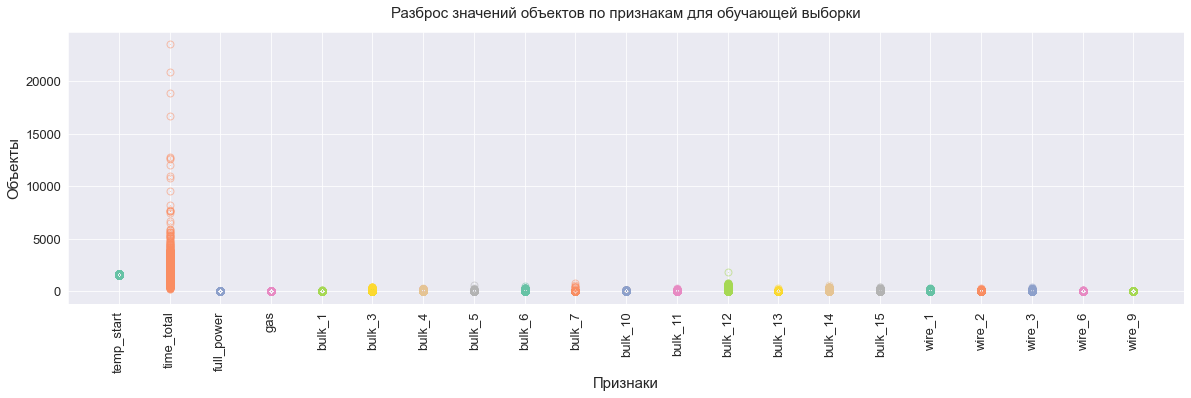

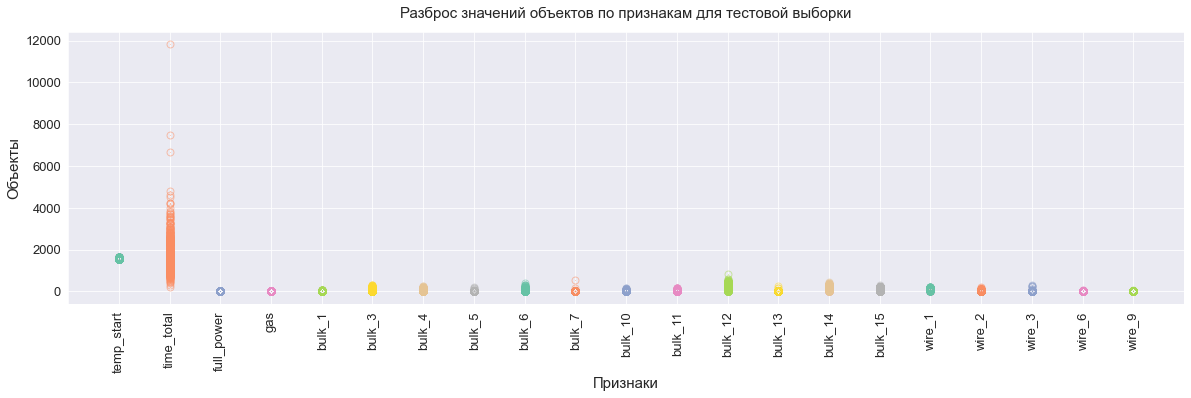

In [88]:
scaling_plot(X_line_train, X_line_test, None)

Т.к. у признаков разный масштаб, то для обучения линейных моделей их необходимо стандартизировать - привести к одному масштабу.

#### Масштабирование

Выполним масштабирование признаков.

In [89]:
numeric = X_line_train.columns

scaler = StandardScaler()
scaler.fit(X_line_train[numeric])
X_line_train[numeric] = scaler.transform(X_line_train[numeric])
X_line_test[numeric] = scaler.transform(X_line_test[numeric])

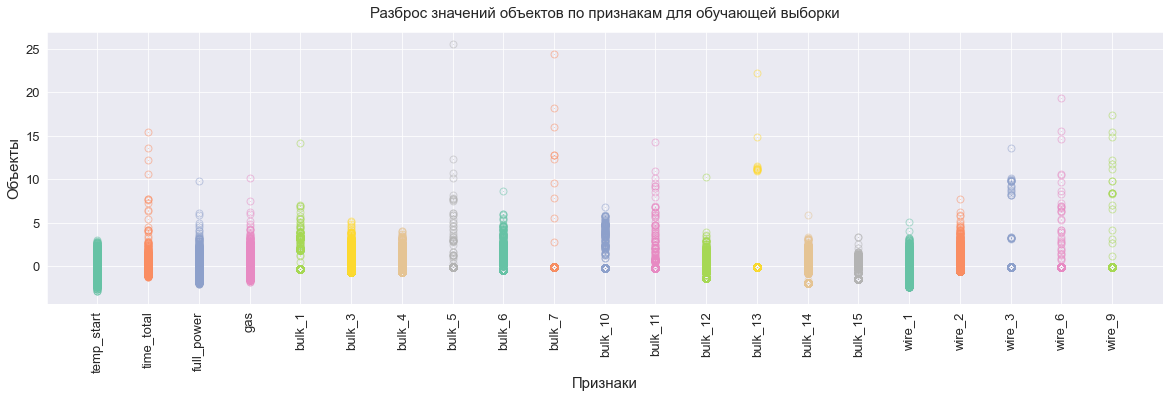

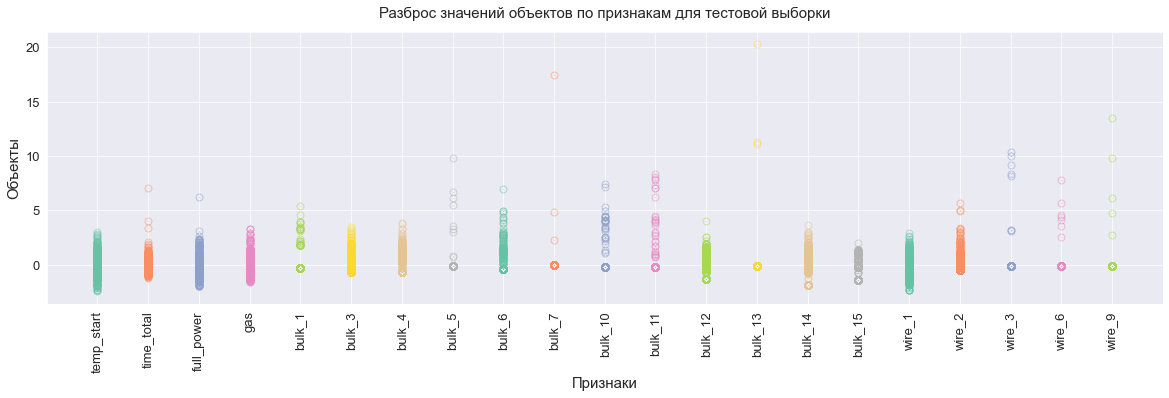

In [90]:
scaling_plot(X_line_train, X_line_test, None)

Признаки приведены к одному масштабу.

## Машинное обучение (ML)

### Сохранение предельного значение метрики MAE в отдельную переменную.

In [91]:
mae_max = 6

### Подбор гиперпараметров

Качество моделей будем проверять на нескольких случайно сформированных выборках при помощи кросс-валидации.

Для этого:
- тестовую выборку «прячем» для финальной проверки;
- обучающую выборку случайным образом делим на K равных частей (метод деления называется K-Fold, где К — это число блоков (англ. folds));
- каждая часть становится валидационной выборкой на одном из К этапов кросс-валидации, остальные части - обучающими;
- каждый раз новая часть становится валидационной выборкой;
- среднее всех оценок, полученных в ходе кросс-валидации, — это и есть оценка качества модели.

#### Функция для поиска гиперпараметров

Создадим функцию `model_search` для поиска лучших гиперпараметров.

На входе:
- `model` - наименование модели
- `parameters` - словарь параметров
- `is_line` - флаг линейности модели (True или False)

Ны выходе:
- `model` - наименование модели
- `params_best` - лучшие параметры модели
- `mae_best` - наименование модели

In [92]:
def model_search (model      :'ModelRegression',
                  parameters : dict,
                  is_line    : bool):    
   
    grid = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_absolute_error')
    
    if is_line == True:
        grid.fit(X_line_train, y_line_train)
    else:
        grid.fit(X_train, y_train)
    
    params_best = grid.best_params_
    mae_best = -grid.best_score_
    
    return model, params_best, mae_best

#### Baseline

Для проверки моделей на вменяемость определим метрику MAE случайной модели.

In [93]:
model_base, params_base, mae_base = model_search (DummyRegressor(),
                                                  parameters = {},
                                                  is_line = False)

In [94]:
print (f'MAE случайной модели {mae_base:.2f}')

MAE случайной модели 8.22


#### Функция проверки качества

Для проверки качества моделей создадим функцию `score_checking`.

На входе:
- `mae` - значение метрики MAE проверяемой модели

Функция ничего не возвращает, служит для определения вменяемости и проверки соответствия качества исходным данным.

In [95]:
def score_checking (mae):
    print (f'MAE = {mae:.2f}')
    if mae < mae_base:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает базовому уровню, модель невменяема.'+color.END)
    
    if mae < mae_max:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает предельному по исходным данным.'+color.END)

#### LinearRegression

Для линейной регрессии ввиду отсутствия необходимости перебора параметров воспользуемся функцией `cross_val_score` из библиотеки `sklearn`, возвращающей список оценок качества моделей. Для вычисления качества необходимо к результатам применить функцию `mean()`.

In [96]:
model_line = LinearRegression()
mae_line = -cross_val_score(model_line, X_line_train, y_line_train, scoring = 'neg_mean_absolute_error', cv=3).mean() 

In [97]:
score_checking (mae_line)

MAE = 5.91
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


#### Lasso

In [98]:
model_lasso, params_lasso, mae_lasso = model_search (Lasso(random_state=seed),
                                                     parameters = {'alpha'        : [0.5, 1, 3, 5],
                                                                   'max_iter'     : [50, 100, 500, 700, 1000],
                                                                   'selection'    : ['cyclic', 'random']},
                                                     is_line = True)

In [99]:
score_checking (mae_lasso)

MAE = 6.09
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.


#### Ridge

In [100]:
model_ridge, params_ridge, mae_ridge = model_search (Ridge(random_state=seed),
                                                     parameters = {'alpha' : range(1000, 30000, 1000)},
                                                     is_line = True)

In [101]:
score_checking (mae_ridge)

MAE = 6.95
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.


#### DecisionTreeRegression

In [102]:
model_tree, params_tree, mae_tree = model_search (DecisionTreeRegressor(random_state=seed),
                                                  parameters = {'max_depth' : range(1, 30, 5)},
                                                  is_line = False)

In [103]:
score_checking (mae_tree)

MAE = 7.46
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.


#### RandomForestRegressor

In [104]:
model_forest, params_forest, mae_forest = model_search (RandomForestRegressor(random_state=seed),
                                                        parameters = {'n_estimators' : range(10, 50, 10),
                                                                      'max_depth'    : range(1, 30, 5)},
                                                        is_line = False)

In [105]:
score_checking (mae_forest)

MAE = 6.19
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.


#### CatBoostRegressor

In [106]:
model_cat, params_cat, mae_cat = model_search (CatBoostRegressor(verbose=False, random_state=seed),
                                               parameters = {'learning_rate' : [0.01, 0.02, 0.03]},
                                               is_line = False)

In [107]:
score_checking (mae_cat)

MAE = 5.80
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


#### LGBMRegressor

In [108]:
model_light, params_light, mae_light = model_search (LGBMRegressor(force_col_wise=True,
                                                                   verbose=0,
                                                                   num_leaves=10,
                                                                   random_state=seed),
                                                       parameters = {'learning_rate'  : [0.05, 0.07, 0.09],
                                                                     'max_depth'      : range(10, 30, 5),
                                                                     'n_estimators'   : [115, 125, 135, 170]},
                                                       is_line = False)

In [109]:
score_checking (mae_light)

MAE = 5.85
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


#### XGBRegressor

In [110]:
model_xg, params_xg, mae_xg = model_search (XGBRegressor(random_state=seed),
                                            parameters = {'learning_rate' : [0.07, 0.1, 0.3],
                                                          'max_depth'     : range(1, 10, 5),
                                                          'n_estimators'  : [95, 200]},
                                            is_line = False)

In [111]:
score_checking (mae_xg)

MAE = 5.87
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


### Выбор лучшей модели 

#### Датафрейм качества моделей

Cохраним лучшую метрику `MAE` каждой модели в датафрейм.

In [112]:
metrics_models = pd.DataFrame(data = {'MAE' : [mae_max,
                                               mae_base,
                                               mae_line,
                                               mae_lasso,
                                               mae_ridge,
                                               mae_tree,
                                               mae_forest,
                                               mae_cat,
                                               mae_light,
                                               mae_xg]},
                              index = ['LimitMetric',
                                       'Baseline',
                                       'LinearRegression',
                                       'Lasso',
                                       'Ridge',
                                       'DecisionTreeRegressor',
                                       'RandomForestRegressor',
                                       'CatBoostRegressor',
                                       'LGBMRegressor',
                                       'XGBRegressor'])

#### Сравнение качества моделей

Для визуального сравнения качества отобразим метрики `MAE` каждой модели на тепловой карте

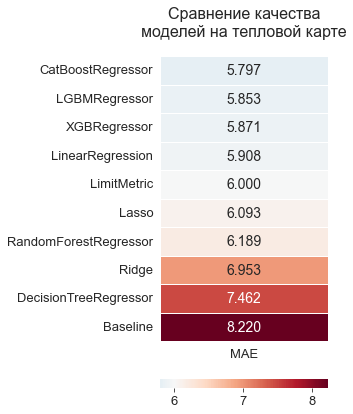

In [113]:
plt.figure(figsize = (3,7))
plt.title(f'Сравнение качества\nмоделей на тепловой карте', y=1.05, fontsize = 16)

sns.heatmap(metrics_models.sort_values(by='MAE'),
            annot=True,
            annot_kws={"size": 14},
            fmt= '.3f',
            cmap= 'RdBu_r',
            linewidths=1.0,
            center=mae_max, cbar_kws={'orientation': 'horizontal', 'pad':0.1});

#### Лучшая модель

In [114]:
metrics_models.loc[metrics_models['MAE']==metrics_models['MAE'].min()]

MAE
CatBoostRegressor 5.797

Сохраним имя лучшей модели в отдельную переменную

In [115]:
best_model_name = metrics_models.loc[metrics_models['MAE']==metrics_models['MAE'].min()].index

### Проверка качества лучшей модели на тестовой выборке

In [116]:
model_best = CatBoostRegressor(**model_cat.get_params(), **params_cat) # инициализация модели с выбранными гиперпараметрами
model_best.fit(X_train, y_train, plot=True)                            # обучение модели
pred_test = model_best.predict(X_test)                                 # предсказания модели на тесте
mae_test = mean_absolute_error(y_test, pred_test)                      # метрика MAE на тесте
score_checking (mae_test)                                              # функция проверки качества

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE = 5.03
Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.


Гиперпараметры лучшей модели

In [117]:
model_best.get_params()

{'learning_rate': 0.02,
 'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 3102022}

## Интерпретация результатов машинного обучения

Упорядочим индексы

In [118]:
y_test = y_test.sort_index(ascending=True)
X_test = X_test.sort_index(ascending=True)
pred_test = pd.DataFrame(pred_test, index=y_test.index).rename(columns={0:'temp_end_pred'}).sort_index(ascending=True)

### Сравнение распределений данных между таргетом и предсказаниями

Объединим таргет, предсказания в общий датасет `target_pred`

In [119]:
target_pred = pd.concat([y_test,
                         pred_test],
                         axis=1)

Сравним распределения на одном графике

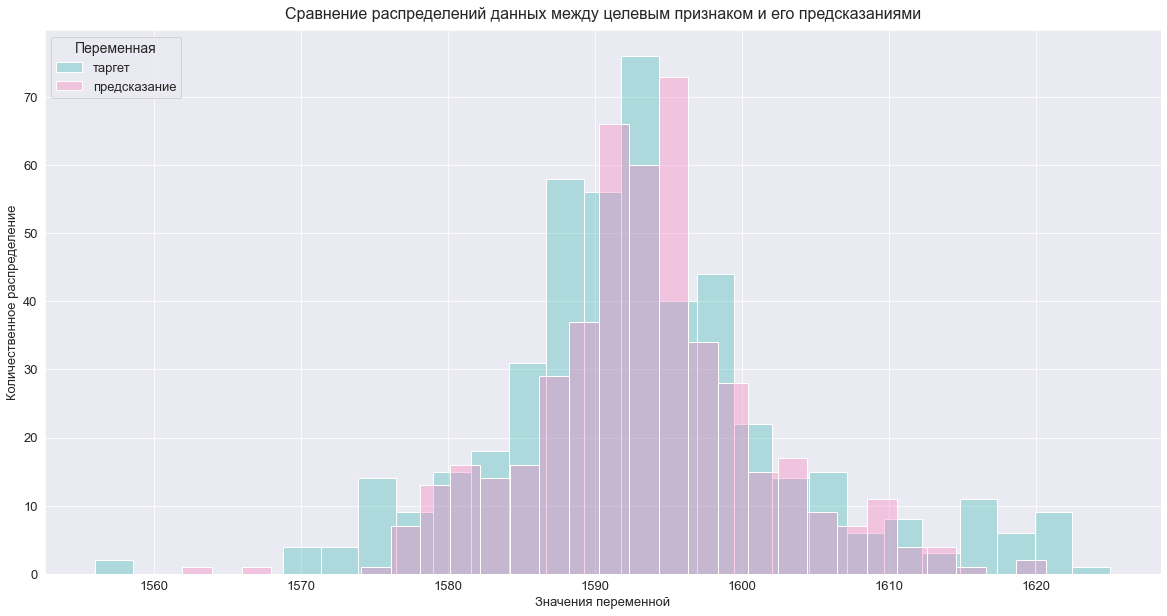

In [120]:
plt.figure(figsize=(20,10))
    
for temp, c in zip(['temp_end', 'temp_end_pred'],
                   ['lightseagreen', 'hotpink']):
    
    sns.histplot(data=target_pred,
                 x=temp,
                 color=c,
                 alpha=.3)        
    
plt.title('Сравнение распределений данных между целевым признаком и его предсказаниями',
          fontsize=16, y=1.01)

plt.legend(['таргет', 'предсказание'],
           title='Переменная',
           title_fontsize = 14,
           loc='upper left')
plt.xlabel('Значения переменной')
plt.ylabel('Количественное распределение')
plt.show()

- Распредения близки к нормальным, смещение данных относительно нормального распределения отрицательно влияет на качество модели.
- Большинство значений предсказаний находятся в диапазоне нормального распределения таргета, выбивающиеся значения предсказываются хуже.

### Визуализация разницы между целевым признаком и предсказаниями

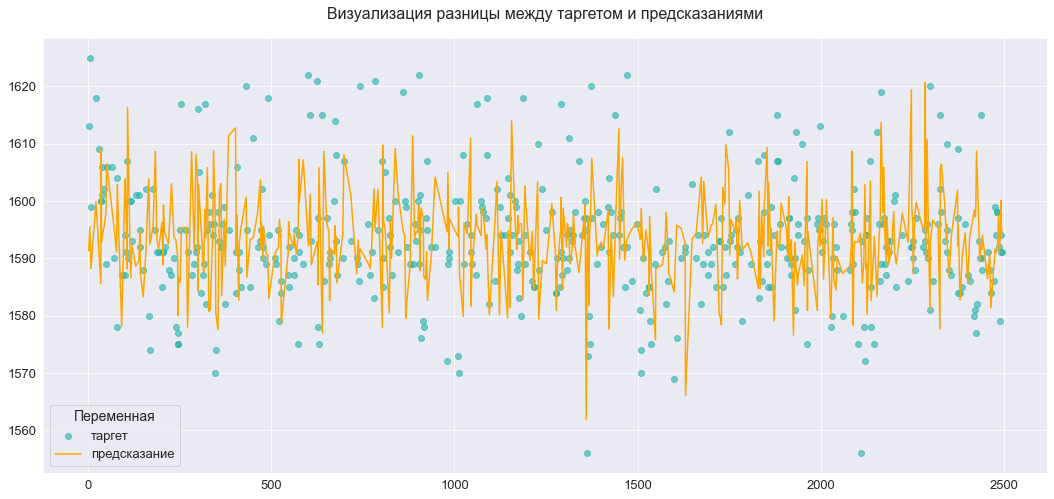

In [121]:
plt.figure(figsize=(18, 8))
plt.scatter(target_pred.index, target_pred['temp_end'], c='lightseagreen', alpha=0.6)
plt.plot(target_pred.index, target_pred['temp_end_pred'], c='orange')
plt.title('Визуализация разницы между таргетом и предсказаниями', fontsize=16, y=1.03)

plt.legend(['таргет', 'предсказание'],
           title='Переменная',
           title_fontsize = 14,
           loc='best');

- Редкие и выбивающиеся значения предсказываются хуже, в чём ещё раз убедились на другом графике.

### Влияние признаков на предсказания

#### Пояснение предсказаний модели с помощью SHAP

In [122]:
explainer = shap.TreeExplainer(model_best)
shap_values = explainer.shap_values(X_test)

#### Подготовка данных

Сохраним список столбцов признаков в отдельную переменную

In [123]:
X_col = X_test.columns

Сохраним список столбцов вкладов признаков в предсказание в отдельную переменную

In [124]:
shap_cols = [x+'_shap' for x in X_col]

Создадим датасет `shap_values_df` из значений вкладов признаков в предсказание

In [125]:
shap_values_df = pd.DataFrame(shap_values, columns = shap_cols, index=y_test.index)

Объединим датасеты `target_pred`, `X_test` и `shap_values_df` в общий датасет `test_shap`

In [126]:
test_shap = pd.concat([target_pred, X_test, shap_values_df], axis=1)

In [127]:
test_shap.head(3)

temp_end  temp_end_pred  temp_start  time_total  full_power    gas  \
key                                                                       
1    1613.000       1591.302    1571.000     861.000       5.826 29.750   
4    1625.000       1595.502    1601.000     388.000       3.815 18.841   
7    1599.000       1588.197    1586.000    1374.000       2.988  9.836   

     bulk_1  bulk_3  bulk_4  bulk_5  ...  bulk_11_shap  bulk_12_shap  \
key                                  ...                               
1     0.000   0.000  43.000   0.000  ...         0.040        -0.185   
4     0.000   0.000  81.000   0.000  ...         0.029         0.098   
7     0.000   0.000 117.000   0.000  ...         0.038         0.079   

     bulk_13_shap  bulk_14_shap  bulk_15_shap  wire_1_shap  wire_2_shap  \
key                                                                       
1           0.002        -0.019         0.916       -2.168        0.760   
4           0.001        -0.115         0.980       -0.422        0.665   
7           0.001        -0.229         0.939        0.339        0.631   

     wire_3_shap  wire_6_shap  wire_9_shap  
key                                         
1          0.007        0.023       -0.000  
4          0.006        0.021       -0.000  
7          0.004        0.022       -0.001  

[3 rows x 44 columns]

Добавим в созданный датасет столбец со значениями ошибок в предсказаниях

In [128]:
test_shap['error'] = test_shap['temp_end_pred'] - test_shap['temp_end']

Посмотрим на распределение ошибок графически

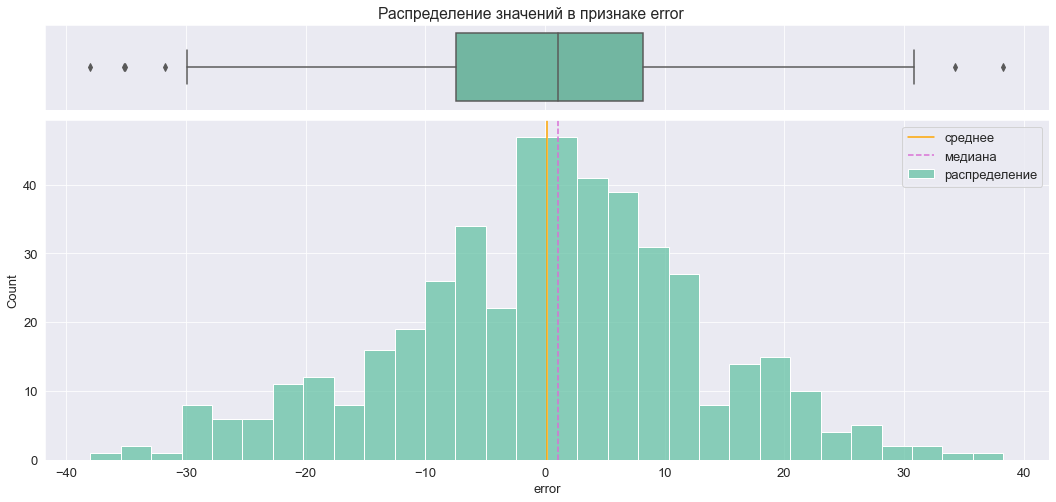

In [129]:
hist_box (test_shap, 'error', bins=30)

- В основном модель отклоняется от целевого признака в диапазоне от -10 до 10.
- Распределение близко к нормальному, модель адекватна, но есть куда стремиться в части модернизации.

Добавим в созданный датасет столбец со значениями абсолютных ошибок в предсказаниях.

In [130]:
test_shap['error_abs'] = abs(test_shap['error'])

Посмотрим на распределение абсолютных ошибок графически.

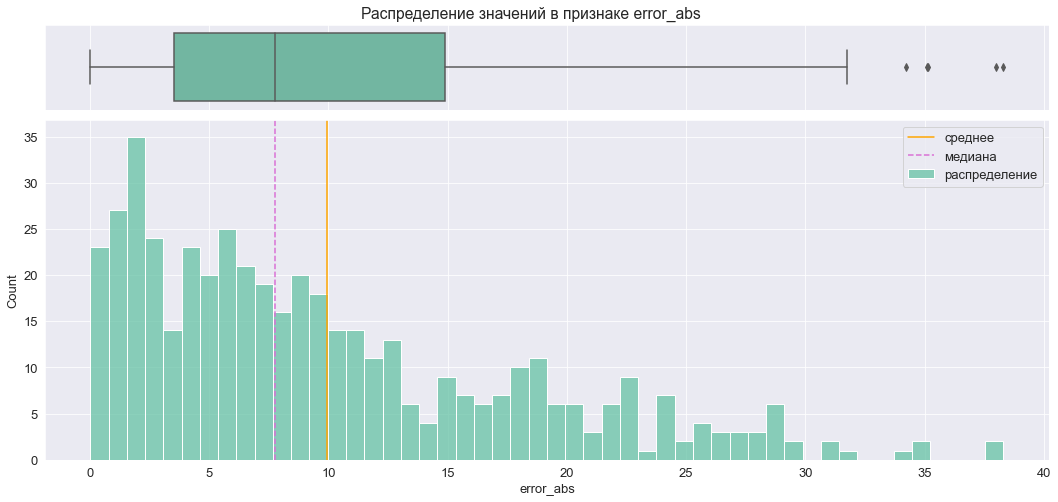

In [131]:
hist_box (test_shap, 'error_abs', bins=50)

- Наблюдения, сделанные ранее стали ещё более наглядными.
- Данные по абсолютной ошибке не совсем нормально распределны. А значит, модель однозначно можно улучшить. Если распределение нормальное - значит ошибки случайные. Если ненормальность - значит в ошибках (остатках) присутствует закономерность. В будущем её следует найти и улучшить модель. Но это тема отдельного проекта.

Отсортируем данные по значениям абсолютной ошибки в порядке убывания и сохраним результат в отдельную переменную.

In [132]:
test_shap_top = test_shap.sort_values('error_abs', ascending=False)

#### Cводный график важности фичей

Построим сводный график важности признаков.
<br>Пояснения к графику:
- по оси x значения вклада в предсказания (значения Шепли),
- признаки расположены на оси y по мере уменьшения их важности,
- каждая точка – отдельное наблюдение,
- чем толще линия на графике, тем больше таких точек наблюдения,
- цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим.

Дополнительно к основному сводному графику добавим столбчатую диаграмму средних значений вкладов признаков в предсказания.

In [133]:
def importance_plot():
    
    fig, _ = plt.subplots()
    
    fig.suptitle('Зависимость предсказаний от признаков по всем вкладам', y=.97, fontsize=15)
    
    shap.summary_plot(shap_values, X_test, plot_size=(15,7), show=False)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Признаки', fontsize=13)
    
    plt.show()
    
    fig, _ = plt.subplots()
    
    fig.suptitle('Сравнение средних значений вкладов признаков в предсказания', y=.97, fontsize=15)
    
    shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(13,6), show=False)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Признаки', fontsize=13)
    
    plt.show()

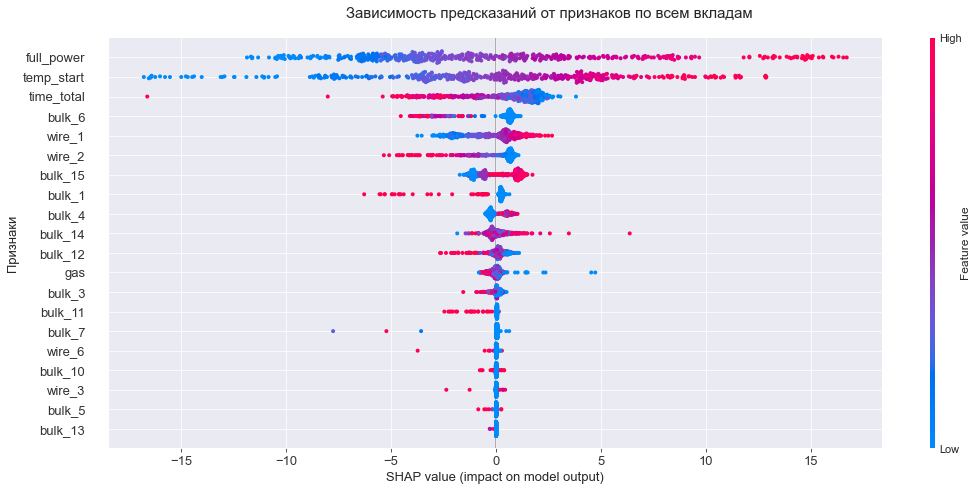

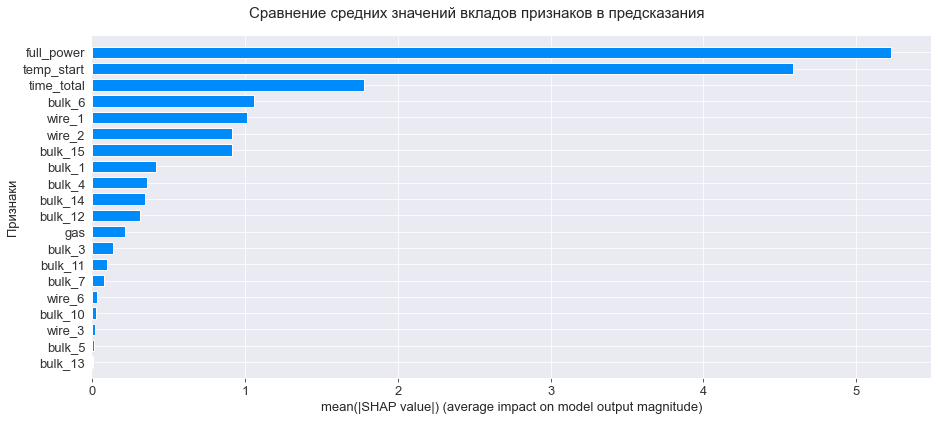

In [134]:
importance_plot()

- Полная мощность вносит максимальный вклад в предсказания, при увеличении значения полной мощности предсказания завышаются.
- Начальная температура на втором месте по вкладу в предсказания, при увеличении значения начальной температуры предсказания завышаются.
- Время от первого до последнего замера на третьем месте по вкладу в предсказания, с увеличением времени предсказания занижаются.
- Остальные признаки вносят меньший вклад в предсказания, как увеличивая, так и уменьшая его.

#### Пояснения к графикам аддитивной силы

Визуализируем заданные значения `SHAP` с помощью графика аддитивной силы.<br>График показывает, как разные признаки влияют на итоговое предсказание модели.
- `base value` (базовое значение) – среднее значение, полученное при обучении;
- жирным выделено полученное значение `base value`;
- если значение вклада положительное (красный цвет), то оно увеличивает предсказание, если отрицательное (синий цвет) - уменьшает;
- графики выполняются как интерактивными, так и в формате библиотеки `matplotlib`, в зависимости от задачи визуализации.

#### Графики аддитивной силы для признаков с максимальными ошибками

Проанализируем объекты с 10 самыми большими абсолютными ошибками.

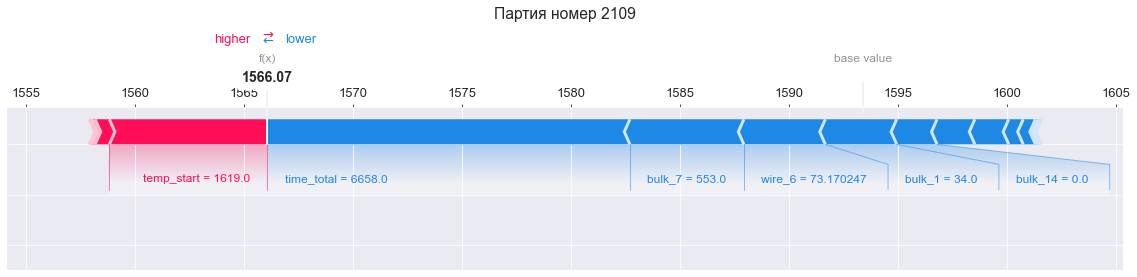

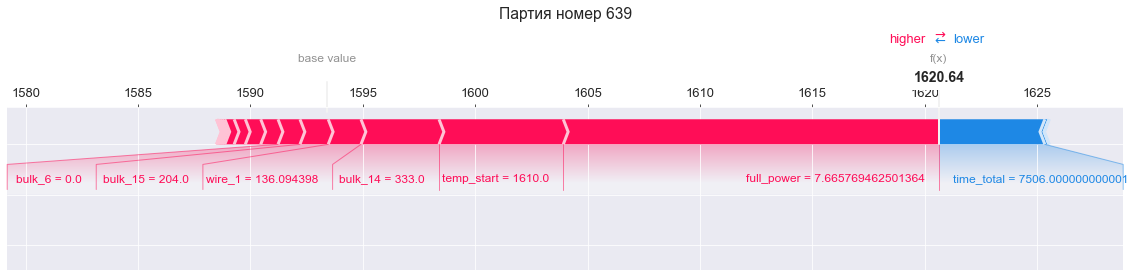

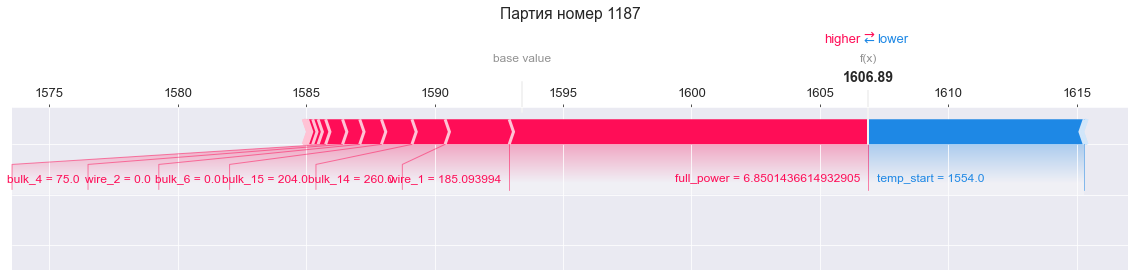

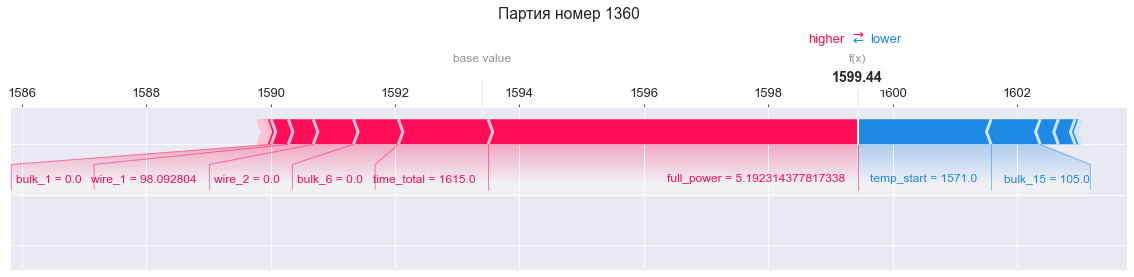

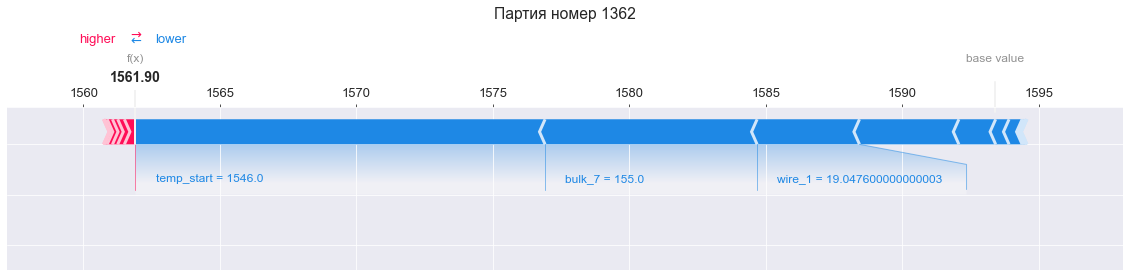

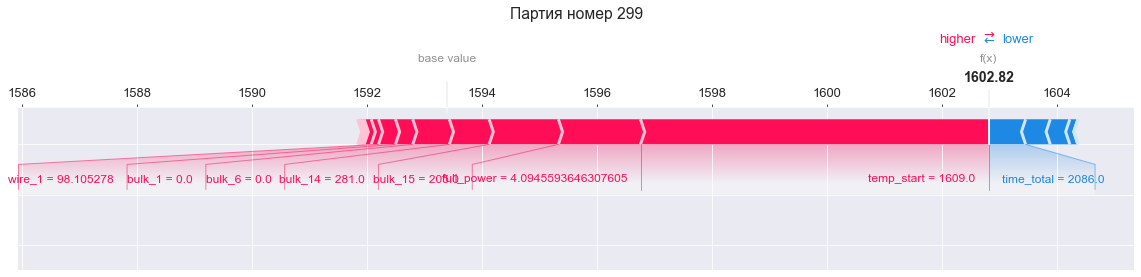

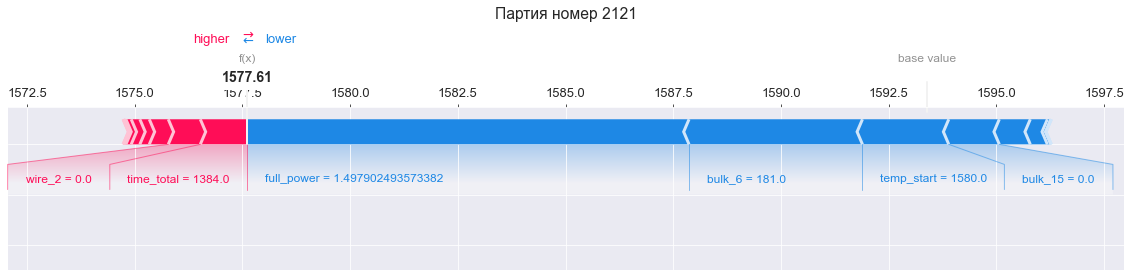

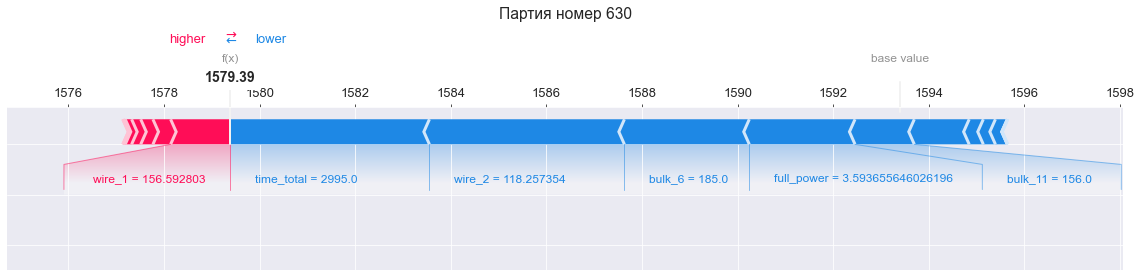

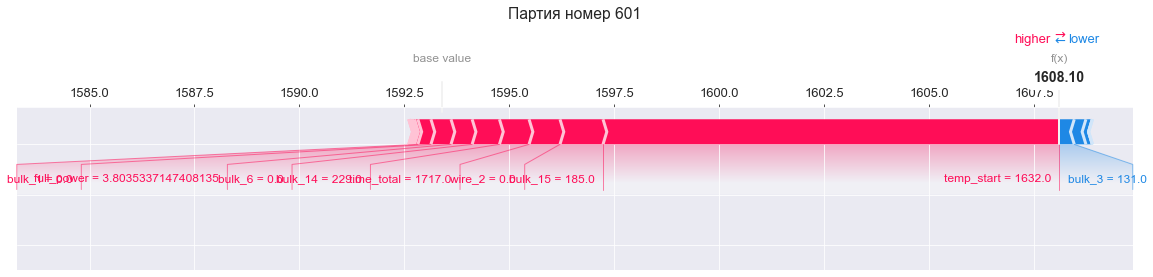

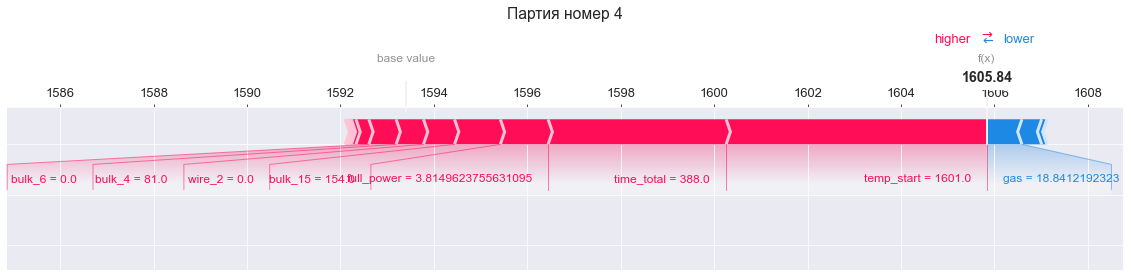

In [135]:
for i in range(10):  
   
    shap.force_plot(explainer.expected_value,
                    test_shap_top[shap_cols].values[i,:],
                    test_shap_top[X_col].iloc[i,:],
                    matplotlib=True, show=0)
    
    plt.title(f'Партия номер {test_shap_top.index[i]}', y=1.5)

Выполним график аддитивной силы сразу для всех 10 объектов.

Мы буквально переворачиваем график, полученный выше, на 90 градусов, и повторяем операцию для каждого наблюдения, а затем соединяем всё в один. Это позволяет увидеть интерпретации сразу для каждого наблюдения.

- Графики выполним в интерактивном формате `javascript`, добавив функцию `shap.initjs()`.
- Для анализа поочередно выбираются и сравниваются признаки в левой центральной части графиков и применяется тип сортировки объектов в признаках в верхней центральной части графиков.

In [136]:
shap.initjs()
shap.force_plot(explainer.expected_value, test_shap_top[shap_cols].head(10).values,
                                          test_shap_top[X_col].head(10))

<ins>Начальная температура:
- признак чаще завышает вклад
- с увеличением полной мощности наблюдается бо́льшая склонность к завышению вклада
- модуль завышения вклада меньше чем модуль занижения вклада 

<ins>Полная мощность:
- признак чаще завышает вклад
- с увеличением полной мощности наблюдается бо́льшая склонность к завышению вклада
- модуль завышения вклада больше чем модуль занижения вклада 
    
<ins>Время от первого до последнего замера:
- признак чаще завышает вклад
- с уменьшением времени наблюдается бо́льшая склонность к завышению вклада
- модуль завышения вклада больше чем модуль занижения вклада 

<ins>Объём сыпучего материала 6, объём проволочного материала 2:
- признак в основном занижает вклад
- с увеличением объема модуль занижения вклада больше
    
<ins>Объём проволочного материала 1:
- признак занижает вклад при значениях < 90: с уменьшением объема модуль занижения выше
- признак завышает вклад при значениях > 90: с увеличением объема модуль завышения выше   
    
<ins>Объём сыпучего материала 15:
- признак занижает вклад при значениях < 120: с уменьшением объема модуль занижения выше
- признак завышает вклад при значениях > 120: с увеличением объема модуль завышения выше 
    
<ins>Объём сыпучего материала 4:
- признак больше завышает вклад, чем занижает
- с увеличением объема модуль завышения вклада растет
    
<ins>Объём сыпучего материала 14:
- признак в основном занижает вклад, чем завышает
- явной закономерности на значение занижения по модулю при изменении значений признака не прослеживается
    
<ins>Объём сыпучего материала 1:
- признак в завышает вклад
- явной закономерности на значение завышения по модулю при изменении значений признака не прослеживается
    
<ins>Объём сыпучего материала 12:
- признак в основном завышает вклад, чем занижает
- явной закономерности на значение завышения по модулю при изменении значений признака не прослеживается
    
<ins>Газ, объём сыпучего материала 3:
- признак как завышает вклад, так и занижает вклад
- явных закономерностей не прослеживается    
- модуль занижения выше, чем модуль завышения
    
<ins>Объём сыпучего материала 11:
- признак завышает вклад при значениях < 30: с уменьшением объема модуль завышения уменьшается
- признак занижает вклад при значениях > 30: с увеличением объема модуль занижения увеличается 
    
<ins>Объём сыпучего материала 7:
- признак в завышает вклад
- с увеличением объема модуль завышения уменьшается
    
Остальные признаки практически не вносят вклад в предсказание. Заказчику будет предложено их не учитывать для дальнейшей модернизации модели.

Добавим в список признаков абсолютную ошибку и сохраним результат в отдельную переменную.

In [137]:
X_error_abs = list(X_col)
X_error_abs.append('error_abs')

Посмотрим разброс значений среди объектов с максимальной абсолютной ошибкой.

In [138]:
cm = sns.light_palette('royalblue', as_cmap=True)
test_shap_top[X_error_abs].head(10).style.background_gradient(cmap=cm)

- Модель сильно ошибается при наличии в исходных данных пропусков, которые были заменены в ходе текущей работы.
- Чаще модель работает с максимальной ошибкой с бо́льшим относительно среднего значения объемом газа, при наличии следующих материалов `bulk_3`, `bulk_4`, `bulk_6`, `bulk_11`, `bulk_12`, `bulk_14`, `bulk_15`, `wire_1`, `wire_2`.
- По начальной температуре, времени закономерностей, полной мощности закономерностей не найдено.

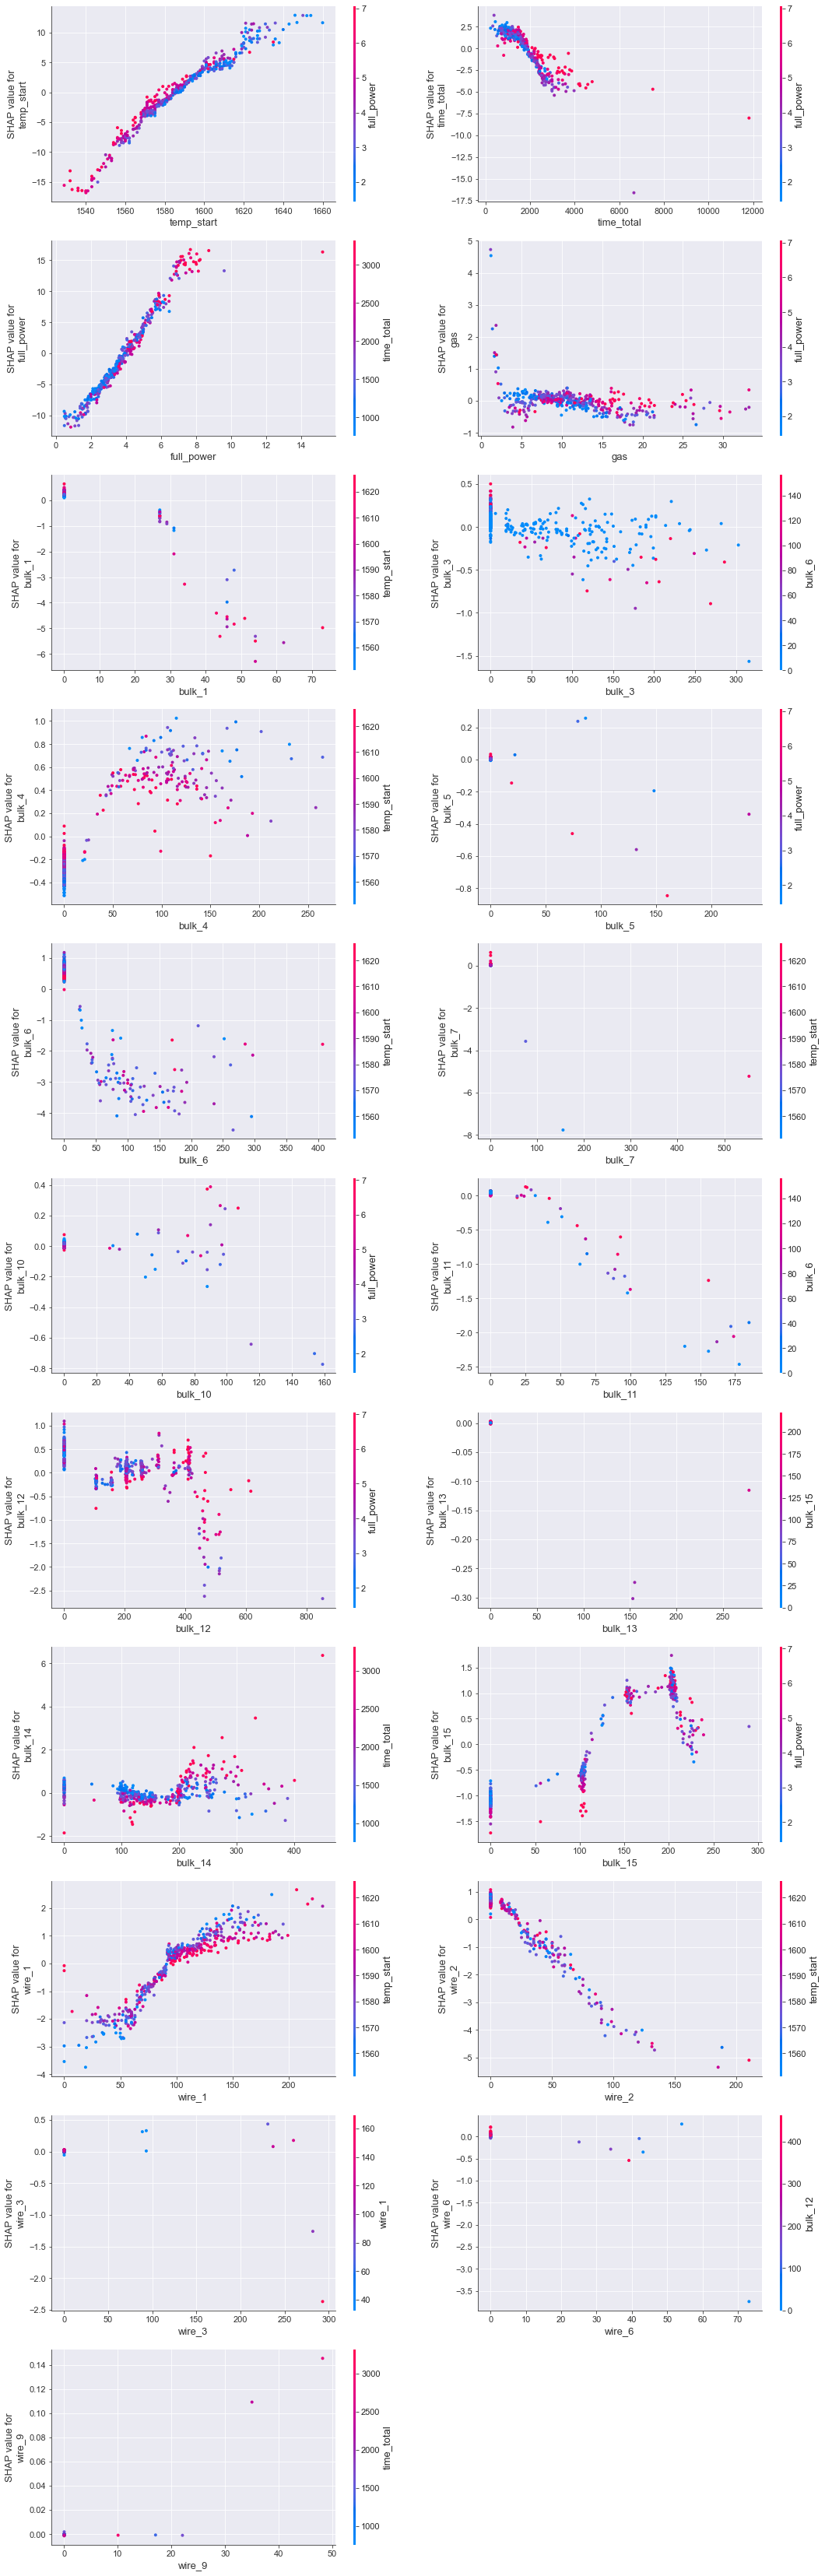

In [139]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(18, 60))
axes = axes.ravel()
fig.delaxes(axes[21])

for i, col in enumerate(X_col):
    
    shap.dependence_plot(col,
                         shap_values,
                         X_test,
                         show=False,
                         ax=axes[i])

<ins>Начальная температура, полная мощность:
- признак как завышает так и занижает вклад
- при увеличении значения признака растет завышение вклада
    
<ins>Время от первого до последнего замера:
- признак в основном занижает вклад
- при увеличении значения признака растет модуль занижения вклада
    
<ins>Газ:
- явных закономерностей нет, наблюдается влияние выбросов, которые не были удалены по требованиям заказчика (особенности технологии), на завышение вклада
- при увеличении значения признака растет модуль занижения вклада
    
<ins>Объём сыпучих материалов 1, 6, 11, 12: 
- при наличии материала в партии - занижает вклад
- при отсутствии - незначительно завышает вклад
    
<ins>Объём сыпучего материала 3: 
- при наличии материала в партии - незначительно занижает вклад
- при отсутствии - незначительно завышает вклад
    
<ins>Объём сыпучего материала 4: 
- при наличии материала в партии - незначительно завышает вклад
- при отсутствии - незначительно занижает вклад
    
<ins>Объём сыпучих материалов 5, 10, 13, проволочных материалов 6, 9: 
- практически не влияет на вклад

<ins>Объём сыпучего материала 7, проволочного материала 3: 
- практически не влияет на вклад
- при редком наличии материала в партии - занижает вклад
    
<ins>Объём сыпучего материала 14: 
- завышает вклад
    
<ins>Объём сыпучего материала 15: 
- признак занижает вклад при значениях < 120
- признак завышает вклад при значениях > 120  
    
<ins>Объём проволочного материала 1: 
- признак занижает вклад при значениях < 100
- признак завышает вклад при значениях > 100 
    
<ins>Объём проволочного материала 2: 
- признак завышает вклад при значениях < 125
- признак занижает вклад при значениях > 125   

Для дальнейшей модернизации модели заказчику будет предложено удалить следующие признаки:
- объёмы сыпучих материалов 5, 10, 13, проволочных материалов 6, 9.

## Отчет

### Решаемая задача

- Цель работы для заказчика уменьшение потребления электроэнергии на этапе обработки стали, т.к. потребление электроэнергии зависит от температуры, то в данном проекте построена модель, предсказывающая последнюю измеренную температуру стали в технологическом процессе.

### Основные этапы работы.

1. От заказчика (**металлургического комбината ООО «Так закаляем сталь»**) получены исходные данные.
2. Проведено совещание с заказчиком на предмет уточнения исходных данных, по результатам которого определены целевой признак, ключевая метрика и получена недостающая информация.
3. Составлен и согласован с заказчиком план работы, все пункты которого были выполнены, т.к. план составлен на основании опыта работы с подобными проектами и учитывал все ньюансы анализа данных и машинного обучения.
4. На протяжении работы был изучен технологический процесс, по результатам полученной информации принимались решения по обработке данных.
5. Проведено EDA исследование данных с учетом изученной технологии.
6. Данные обработаны для машинного обучения, с учетом анализа взаимосвязей и выбора подходящих факторов.
7. Проведено машинное обучение, включая выбор лучшей модели с лучшими гиперпараметрами на кросс-валидации.
8. Выбрана лучшая по критериям заказчика модель и проверена на тестовой выборке.
9. Проведена интерпретация результатов машинного обучения.
10. Заказчику представлены модель и решения для дальнейшей модернизации модели.

### Результат решения

- Лучшая модель ```CatBoostRegressor(learning_rate=0.02, verbose=False, random_state=3102022)```
- Метрика лучшей модели MAE = 5.07

### Факторы модели

Факторы модели и их вклад в предсказание показаны на графиках важности важности признаков.

Пояснения к основному сводному графику (первому):
- по оси x значения вклада в предсказания (значения Шепли),
- признаки расположены на оси y по мере уменьшения их важности,
- каждая точка – отдельное наблюдение,
- чем толще линия на графике, тем больше таких точек наблюдения,
- цветом обозначены значения соответствующего признака: высокие – красным , низкие – синим.

Дополнительно к первому графику показана столбчатая диаграмма средних значений вкладов признаков в предсказания.

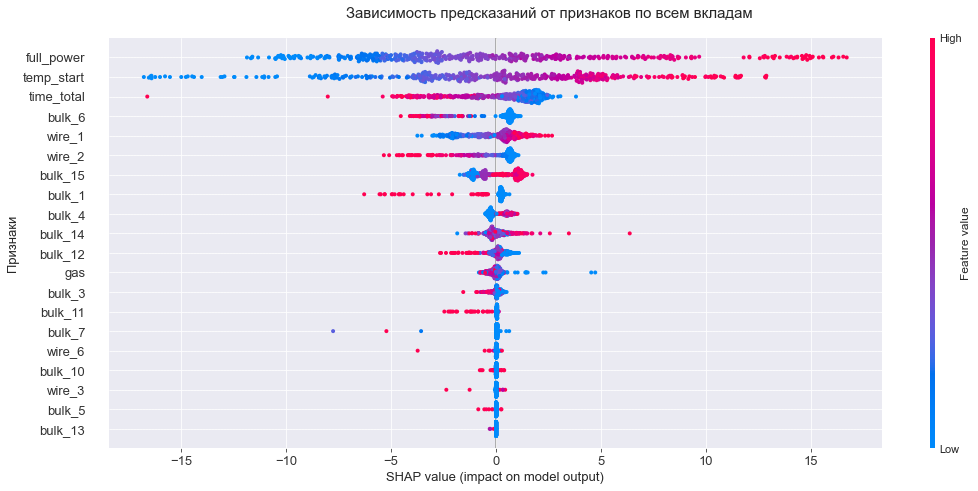

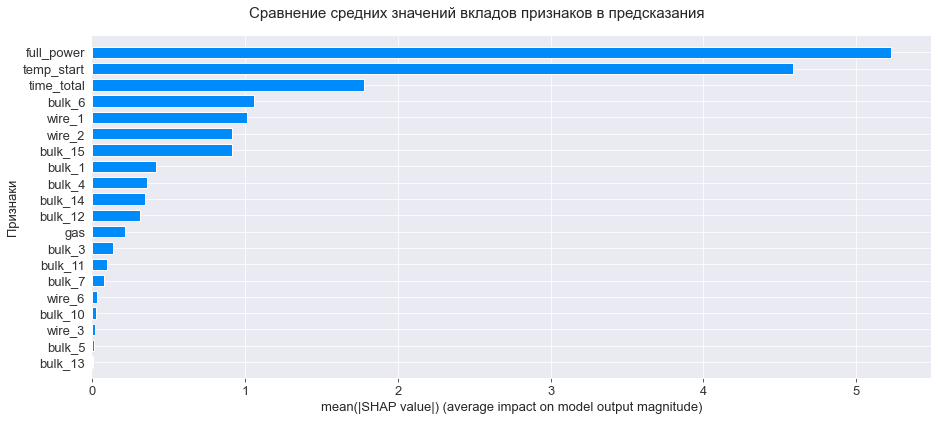

In [140]:
importance_plot()

- Цель заказчика - экономия энергоресурсов, за энергоресурсы как раз отвечает фактор номер один - полная мощность, он больше всего влияет на предсказание финальной температуры.
- Судя по модели самым важным фактором для задачи проекта является первая температура. Это значит, что, управляя первой температурой, мы сможем управлять энергозатратами.
- Далее заказчику нужно разработать мероприятия для этого решения, а предложенная модель - только начало работы над энергоэффективностью.

### Решение по модернизации модели в будущем.

Точно предсказать температуру невозможно ввиду особенностей физических процессов, технологии производства, а также погрешности измерений.

Для модернизации модели в будущем предлагается следующий план:

1. Следует уменьшить разброс в измерениях.
2. Определить границы, в пределах которых колебания температур допустимо.
3. Далее фикcировать партии, где температура выходит за эти границы и помечать флагом (к примеру `1`).
4. Для выявленных отклонений от нормальной темпратуры собирать информацию по составу материала, газа, какая бригада работала, какие показатели были у электродов, иные технологические факторы.
5. Поиск причин отклонений при помощи науки о данных.
6. Фиксация причин.
7. Разработка мероприятий по энергосбережению.